In [1]:
# Mounting/Connecting Google drive contents
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Importing all the necessary packages
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

In [3]:

# Loading the Targeted Metabolomics dataset from the Excel file
file_path = '/content/drive/MyDrive/Colab Notebooks/data_for_douglas 2/targetedMetabolomics_analysis20230905_SORTED.xlsx'
metabolomics_df = pd.read_excel(file_path)

# Sorting the dataset by 'padj' values in ascending order
sorted_metabolomics_df = metabolomics_df.sort_values(by='padj', ascending=True)

# Selecting the first 500 rows from the sorted DataFrame
top_500_metabolomics_df = sorted_metabolomics_df.head(500)

# Saving the top 500 rows to a new Excel file
output_file_path = '/content/drive/MyDrive/Colab Notebooks/data_for_douglas 2/TargetedMetabolomics_First500.xlsx'
top_500_metabolomics_df.to_excel(output_file_path, index=False, sheet_name='Top_500')

print("The first 500 sorted entries have been saved to:", output_file_path)



The first 500 sorted entries have been saved to: /content/drive/MyDrive/Colab Notebooks/data_for_douglas 2/TargetedMetabolomics_First500.xlsx


In [4]:
# Loading the Metabolomics dataset
metabolomics_file_path = '/content/drive/MyDrive/Colab Notebooks/data_for_douglas 2/TargetedMetabolomics_First500.xlsx'
metabolomics_df = pd.read_excel(metabolomics_file_path)

# Loading the Transcriptomics datasets
transcriptomics_1_file_path = '/content/drive/MyDrive/Colab Notebooks/data_for_douglas 2/transcriptomics/ko_analysisresults_v4.xlsx'
transcriptomics_2_file_path = '/content/drive/MyDrive/Colab Notebooks/data_for_douglas 2/transcriptomics/kooe_analysisresults_v4.xlsx'
transcriptomics_3_file_path = '/content/drive/MyDrive/Colab Notebooks/data_for_douglas 2/transcriptomics/wtoe_analysisresults_v4.xlsx'

transcriptomics_df1 = pd.read_excel(transcriptomics_1_file_path)
transcriptomics_df2 = pd.read_excel(transcriptomics_2_file_path)
transcriptomics_df3 = pd.read_excel(transcriptomics_3_file_path)

In [5]:
# Checking for missing data in Metabolomics dataset
print("Missing data in Metabolomics dataset:")
print(metabolomics_df.isnull().sum())

# Checking for missing data in Transcriptomics datasets
print("Missing data in Transcriptomics dataset 1:")
print(transcriptomics_df1.isnull().sum())
print("Missing data in Transcriptomics dataset 2:")
print(transcriptomics_df2.isnull().sum())
print("Missing data in Transcriptomics dataset 3:")
print(transcriptomics_df3.isnull().sum())


Missing data in Metabolomics dataset:
cell_line_name    0
SLC               0
metabolite        0
log2FC            0
padj              0
dtype: int64
Missing data in Transcriptomics dataset 1:
analysisID                         0
ensembl_gene_id                    0
analysisName                       0
baseMean                           0
log2FoldChange                     0
lfcSE                              0
pvalue                        152417
padj                          350421
external_gene_name             26864
is_sign                       350421
countMark                     578324
Parental_cell                      0
changing_in_Renilla_clones    894028
dtype: int64
Missing data in Transcriptomics dataset 2:
ensembl_gene_id             0
analysisID                  0
analysisName                0
baseMean                    0
log2FoldChange              0
lfcSE                       0
pvalue                  91121
padj                   268617
external_gene_name        486

In [6]:
# Function to identify numeric columns to exclude pvalue and padj
def get_numeric_columns(df, exclude_cols):
    return df.select_dtypes(include=['float64', 'int64']).columns.difference(exclude_cols)

exclude_cols = ['pvalue', 'padj']

# Numeric columns for each dataset
numeric_cols_metabolomics = get_numeric_columns(metabolomics_df, exclude_cols)
numeric_cols_transcriptomics1 = get_numeric_columns(transcriptomics_df1, exclude_cols)
numeric_cols_transcriptomics2 = get_numeric_columns(transcriptomics_df2, exclude_cols)
numeric_cols_transcriptomics3 = get_numeric_columns(transcriptomics_df3, exclude_cols)

# Performing initial simple imputation for numeric columns
metabolomics_df[numeric_cols_metabolomics] = metabolomics_df[numeric_cols_metabolomics].fillna(metabolomics_df[numeric_cols_metabolomics].mean())
transcriptomics_df1[numeric_cols_transcriptomics1] = transcriptomics_df1[numeric_cols_transcriptomics1].fillna(transcriptomics_df1[numeric_cols_transcriptomics1].median())
transcriptomics_df2[numeric_cols_transcriptomics2] = transcriptomics_df2[numeric_cols_transcriptomics2].fillna(transcriptomics_df2[numeric_cols_transcriptomics2].median())
transcriptomics_df3[numeric_cols_transcriptomics3] = transcriptomics_df3[numeric_cols_transcriptomics3].fillna(transcriptomics_df3[numeric_cols_transcriptomics3].median())

# Droping 'changing_in_GFP' column from Transcriptomics 3 due to excessive missing data
transcriptomics_df3_clean = transcriptomics_df3.drop(columns=['changing_in_GFP'])

# Rechecking for any remaining NaNs after the initial imputation
print("Remaining NaNs in Metabolomics after initial imputation:")
print(metabolomics_df[numeric_cols_metabolomics].isnull().sum())

print("Remaining NaNs in Transcriptomics 1 after initial imputation:")
print(transcriptomics_df1[numeric_cols_transcriptomics1].isnull().sum())

print("Remaining NaNs in Transcriptomics 2 after initial imputation:")
print(transcriptomics_df2[numeric_cols_transcriptomics2].isnull().sum())

print("Remaining NaNs in Transcriptomics 3 after dropping 'changing_in_GFP':")
print(transcriptomics_df3_clean[numeric_cols_transcriptomics3.difference(['changing_in_GFP'])].isnull().sum())

# Scaling the numeric data before performing KNN imputation
scaler_metabolomics = StandardScaler()
scaled_metabolomics = scaler_metabolomics.fit_transform(metabolomics_df[numeric_cols_metabolomics])

scaler_transcriptomics1 = StandardScaler()
scaler_transcriptomics2 = StandardScaler()
scaler_transcriptomics3 = StandardScaler()

scaled_transcriptomics1 = scaler_transcriptomics1.fit_transform(transcriptomics_df1[numeric_cols_transcriptomics1])
scaled_transcriptomics2 = scaler_transcriptomics2.fit_transform(transcriptomics_df2[numeric_cols_transcriptomics2])
scaled_transcriptomics3 = scaler_transcriptomics3.fit_transform(transcriptomics_df3_clean[numeric_cols_transcriptomics3.difference(['changing_in_GFP'])])

# KNN imputation for numeric columns with number of neighbors set to 3
knn_imputer = KNNImputer(n_neighbors=3)

# Applying KNN imputation
scaled_metabolomics_imputed = knn_imputer.fit_transform(scaled_metabolomics)
scaled_transcriptomics1_imputed = knn_imputer.fit_transform(scaled_transcriptomics1)
scaled_transcriptomics2_imputed = knn_imputer.fit_transform(scaled_transcriptomics2)
scaled_transcriptomics3_imputed = knn_imputer.fit_transform(scaled_transcriptomics3)

# Reverting the scaling after imputation
metabolomics_df_imputed = metabolomics_df.copy()
transcriptomics_df1_imputed = transcriptomics_df1.copy()
transcriptomics_df2_imputed = transcriptomics_df2.copy()
transcriptomics_df3_imputed = transcriptomics_df3_clean.copy()

metabolomics_df_imputed[numeric_cols_metabolomics] = scaler_metabolomics.inverse_transform(scaled_metabolomics_imputed)
transcriptomics_df1_imputed[numeric_cols_transcriptomics1] = scaler_transcriptomics1.inverse_transform(scaled_transcriptomics1_imputed)
transcriptomics_df2_imputed[numeric_cols_transcriptomics2] = scaler_transcriptomics2.inverse_transform(scaled_transcriptomics2_imputed)
transcriptomics_df3_imputed[numeric_cols_transcriptomics3.difference(['changing_in_GFP'])] = scaler_transcriptomics3.inverse_transform(scaled_transcriptomics3_imputed)

# Ensuring 'numeric_cols_transcriptomics3' does not include 'changing_in_GFP'
numeric_cols_transcriptomics3 = numeric_cols_transcriptomics3.difference(['changing_in_GFP'])


Remaining NaNs in Metabolomics after initial imputation:
log2FC    0
dtype: int64
Remaining NaNs in Transcriptomics 1 after initial imputation:
baseMean          0
is_sign           0
lfcSE             0
log2FoldChange    0
dtype: int64
Remaining NaNs in Transcriptomics 2 after initial imputation:
baseMean          0
contrastId        0
is_sign           0
lfcSE             0
log2FoldChange    0
dtype: int64
Remaining NaNs in Transcriptomics 3 after dropping 'changing_in_GFP':
baseMean          0
group             0
is_sign           0
lfcSE             0
log2FoldChange    0
dtype: int64


In [7]:
# Function to remove outliers, avoiding pvalue and padj columns
def remove_outliers(df, exclude_cols):
    numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns.difference(exclude_cols)

    # Calculating Q1, Q3, and IQR for numeric columns
    Q1 = df[numeric_cols].quantile(0.25)
    Q3 = df[numeric_cols].quantile(0.75)
    IQR = Q3 - Q1

    # Identifying and filter out outliers
    df_out = df[~((df[numeric_cols] < (Q1 - 1.5 * IQR)) | (df[numeric_cols] > (Q3 + 1.5 * IQR))).any(axis=1)]

    return df_out

# Applying outlier removal to Metabolomics and Transcriptomics datasets
metabolomics_df_clean = remove_outliers(metabolomics_df_imputed, exclude_cols)
transcriptomics_df1_clean = remove_outliers(transcriptomics_df1_imputed, exclude_cols)
transcriptomics_df2_clean = remove_outliers(transcriptomics_df2_imputed, exclude_cols)
transcriptomics_df3_clean = remove_outliers(transcriptomics_df3_imputed, exclude_cols)

print("Cleaned Metabolomics Dataset:\n", metabolomics_df_clean.head())
print("Cleaned Transcriptomics Dataset 1:\n", transcriptomics_df1_clean.head())
print("Cleaned Transcriptomics Dataset 2:\n", transcriptomics_df2_clean.head())
print("Cleaned Transcriptomics Dataset 3:\n", transcriptomics_df3_clean.head())

Cleaned Metabolomics Dataset:
                     cell_line_name       SLC              metabolite  \
3    HCT116-SLC5A6-KOOE-Ct-R100268    SLC5A6        Pantothenic acid   
5  HCT116-SLC25A32-KOOE-Ct-R100236  SLC25A32                   AICAR   
6      HCT116-MPC1-KOOE-Ct-R100252      MPC1   N-Acetylglutamic acid   
7  HCT116-SLC25A37-KOOE-Ct-R100230  SLC25A37  Dimethyl Succinic acid   
8  HCT116-SLC25A14-KOOE-Nt-R100230  SLC25A14    Hydroxyglutaric acid   

     log2FC          padj  
3  1.772740  1.780000e-13  
5 -2.436065  3.520000e-12  
6  1.103969  3.930000e-12  
7  0.788077  4.400000e-12  
8 -0.617463  6.800000e-12  
Cleaned Transcriptomics Dataset 1:
       analysisID  ensembl_gene_id                 analysisName   baseMean  \
52546   AN0151-5  ENSG00000139269  SLC25A15 KO: KO vs. Renilla   36.45490   
52848   AN014G-Y  ENSG00000143882  SLC25A43 KO: KO vs. Renilla  171.69050   
52937   AN014Z-R  ENSG00000171533  SLC25A14 KO: KO vs. Renilla   52.50861   
53329   AN0155-B  ENSG00

In [8]:
# Saving cleaned data as new Excel files
metabolomics_df_clean.to_excel('/content/drive/MyDrive/Colab Notebooks/data_for_douglas 2/cleaned_targeted_metabolomics.xlsx', index=False)
transcriptomics_df1_clean.to_excel('/content/drive/MyDrive/Colab Notebooks/data_for_douglas 2/cleaned_transcriptomics1.xlsx', index=False)
transcriptomics_df2_clean.to_excel('/content/drive/MyDrive/Colab Notebooks/data_for_douglas 2/cleaned_transcriptomics2.xlsx', index=False)
transcriptomics_df3_clean.to_excel('/content/drive/MyDrive/Colab Notebooks/data_for_douglas 2/cleaned_transcriptomics3.xlsx', index=False)


# **Volcano Plot**

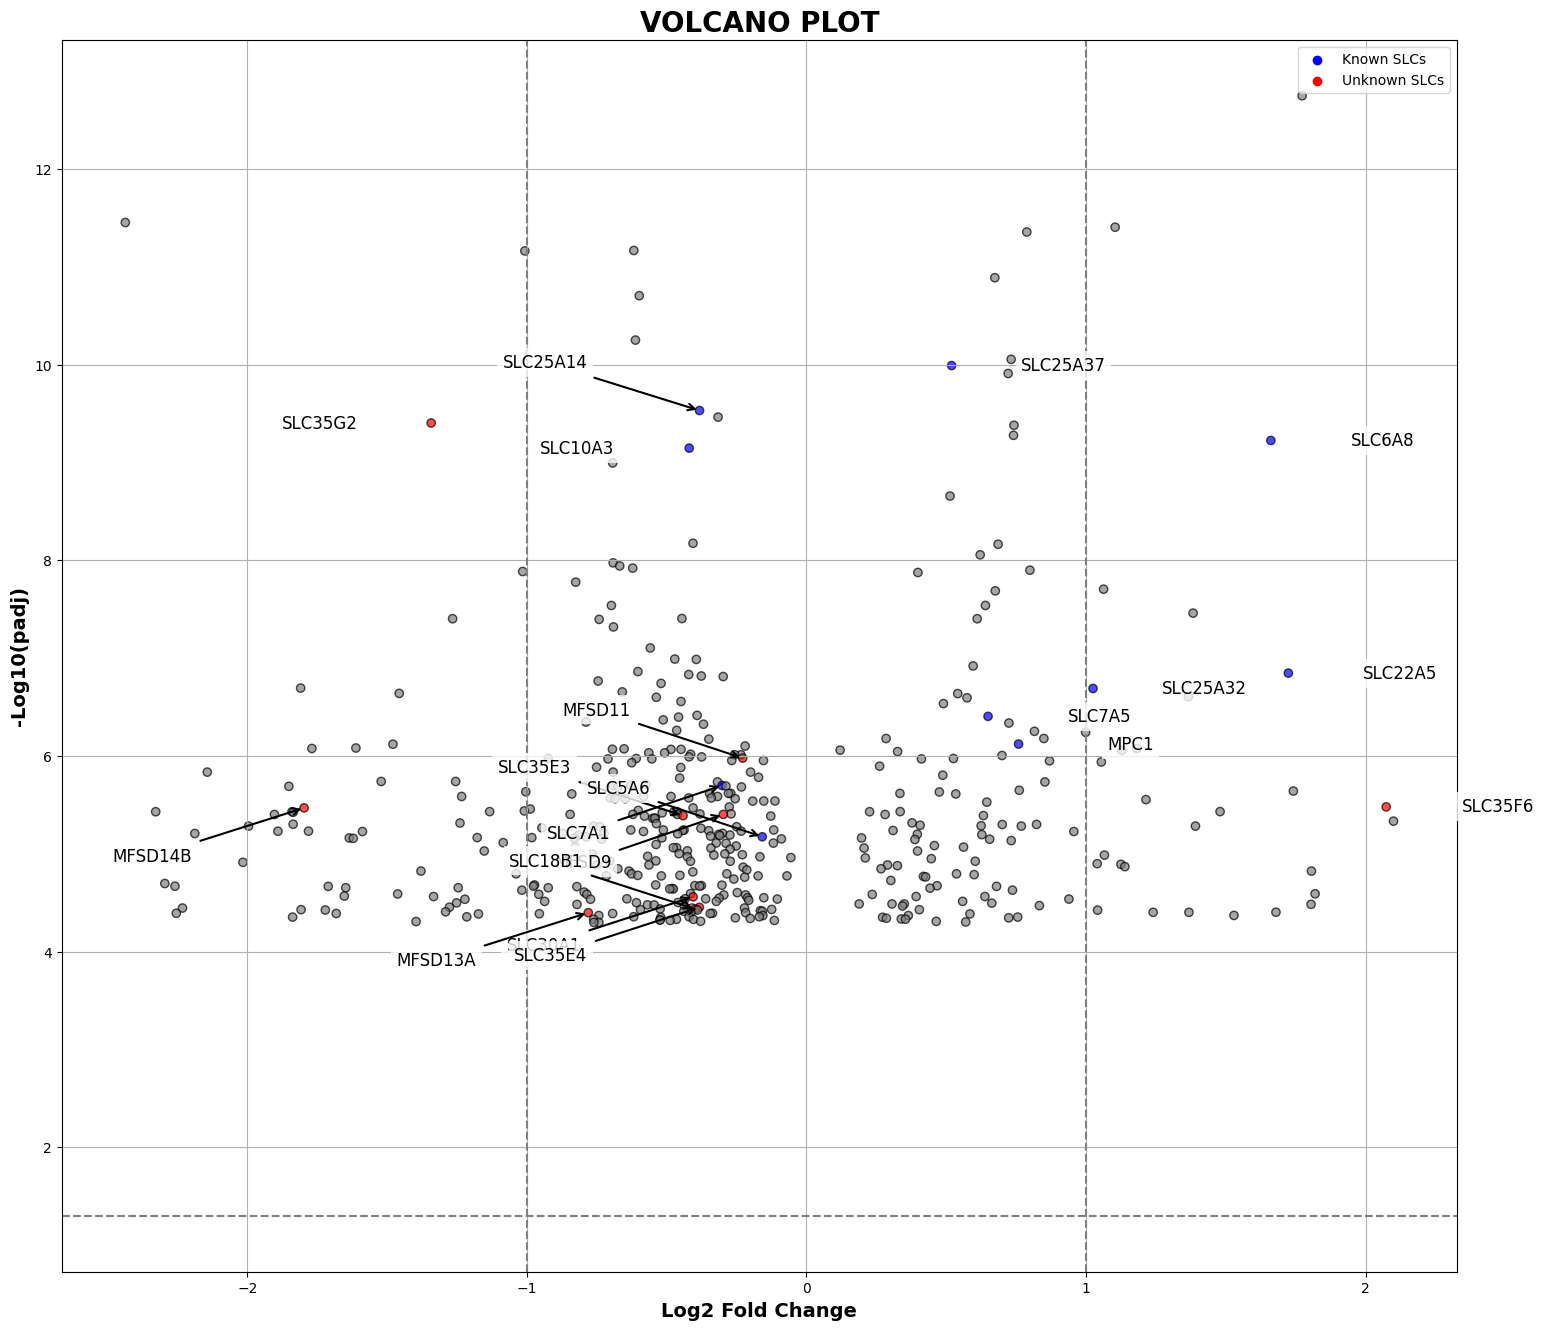

In [9]:
# Importing necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Loading data from the Excel file
file_path = '/content/drive/MyDrive/Colab Notebooks/data_for_douglas 2/cleaned_targeted_metabolomics.xlsx'
sheet_name = 'Sheet1'

# Reading the Excel file into a DataFrame
df = pd.read_excel(file_path, sheet_name=sheet_name)

# Manually specifying the known and unknown SLCs
known_slcs = [
    {'cell_line_name': 'HCT116-SLC25A37-KOOE-Ct-R100230', 'SLC': 'SLC25A37', 'metabolite': 'N-Acetylglutamic acid'},
    {'cell_line_name': 'HCT116-SLC25A14-KOOE-Nt-R100230', 'SLC': 'SLC25A14', 'metabolite': 'N-Acetylglutamic acid'},
    {'cell_line_name': 'HCT116-SLC6A8-KOOE-Ct-R100356', 'SLC': 'SLC6A8', 'metabolite': 'Creatinine'},
    {'cell_line_name': 'HCT116-SLC10A3-KOOE-Ct-R100230', 'SLC': 'SLC10A3', 'metabolite': 'N-Carbamoyl-aspartic acid'},
    {'cell_line_name': 'HCT116-SLC22A5-KOOE-Ct-R100181', 'SLC': 'SLC22A5', 'metabolite': 'Acetylcarnitine'},
    {'cell_line_name': 'HCT116-SLC25A32-KOOE-Ct-R100236', 'SLC': 'SLC25A32', 'metabolite': 'Glycine'},
    {'cell_line_name': 'HCT116-SLC7A5-KOOE-Ct-R100240', 'SLC': 'SLC7A5', 'metabolite': 'Tyrosine'},
    {'cell_line_name': 'HCT116-MPC1-KOOE-Ct-R100252', 'SLC': 'MPC1', 'metabolite': 'cis-Aconitic acid'},
    {'cell_line_name': 'HCT116-SLC7A1-KOOE-Ct-R100268', 'SLC': 'SLC7A1', 'metabolite': 'Tryptophan'},
    {'cell_line_name': 'HCT116-SLC5A6-KOOE-Ct-R100268', 'SLC': 'SLC5A6', 'metabolite': 'Citric acid+Isocitric acid'}
]

unknown_slcs = [
    {'cell_line_name': '1321N1-SLC35G2-KOOE-Ct-R100230', 'SLC': 'SLC35G2', 'metabolite': 'Aminoadipic acid'},
    {'cell_line_name': 'HCT116-MFSD11-KOOE-Ct-R100239', 'SLC': 'MFSD11', 'metabolite': 'Pantothenic acid'},
    {'cell_line_name': 'HEK-SLC35F6-WTOE-Ct-R100290', 'SLC': 'SLC35F6', 'metabolite': 'Pantothenic acid'},
    {'cell_line_name': 'HEK-MFSD14B-WTOE-Nt-R100290', 'SLC': 'MFSD14B', 'metabolite': 'Aspartic Acid'},
    {'cell_line_name': 'HCT116-MFSD9-KOOE-Ct-R100239', 'SLC': 'MFSD9', 'metabolite': 'cis-Aconitic acid'},
    {'cell_line_name': 'HCT116-SLC35E3-KOOE-Ct-R100285', 'SLC': 'SLC35E3', 'metabolite': 'Aconitic acid'},
    {'cell_line_name': 'HCT116-SLC30A1-KOOE-Ct-R100226', 'SLC': 'SLC30A1', 'metabolite': 'Taurine'},
    {'cell_line_name': 'HCT116-SLC35E4-KOOE-Ct-R100285', 'SLC': 'SLC35E4', 'metabolite': 'Uridine diphosphohexose'},
    {'cell_line_name': 'HCT116-SLC18B1-KOOE-Ct-R100315', 'SLC': 'SLC18B1', 'metabolite': 'Aconitic acid'},
    {'cell_line_name': 'HEK-MFSD13A-WTOE-Ct-R100290', 'SLC': 'MFSD13A', 'metabolite': 'Aminoadipic acid'}
]

# Adding a color column based on whether the SLC is known or unknown
df['color'] = 'gray'
df['category'] = 'Other'

# Function to match rows with known or unknown SLCs
def match_slcs(row, slcs_list, category_name, color):
    for slc in slcs_list:
        if (row['cell_line_name'] == slc['cell_line_name']) and (row['SLC'] == slc['SLC']) and (row['metabolite'] == slc['metabolite']):
            return pd.Series([category_name, color])
    return pd.Series([row['category'], row['color']])

# Applying the function to assign colors and categories
df[['category', 'color']] = df.apply(lambda row: match_slcs(row, known_slcs, 'Known SLCs', 'blue'), axis=1)
df[['category', 'color']] = df.apply(lambda row: match_slcs(row, unknown_slcs, 'Unknown SLCs', 'red'), axis=1)

# Converting padj to -log10(padj) for plotting
df['-log10(padj)'] = -np.log10(df['padj'])

# Plotting the volcano plot
plt.figure(figsize=(18,16))
plt.scatter(df['log2FC'], df['-log10(padj)'], c=df['color'], alpha=0.7, edgecolor='k')

# Defining a small distance threshold for using arrows instead of direct labels
distance_threshold = 0.1
offset = 0.4

# Function to calculate the Euclidean distance between two points
def calculate_distance(x1, y1, x2, y2):
    return np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)

# Adding labels close to the points or use arrows if points are close
for i, row in df.iterrows():
    if row['category'] in ['Known SLCs', 'Unknown SLCs']:
        x, y = row['log2FC'], row['-log10(padj)']
        label_placed = False

        for j, other_row in df.iterrows():
            if i != j and calculate_distance(x, y, other_row['log2FC'], other_row['-log10(padj)']) < distance_threshold:
                # If another point is very close, use an arrow
                if x > 0:
                    x_text = x + offset
                    ha = 'left'
                else:
                    x_text = x - offset
                    ha = 'right'

                if i % 2 == 0:
                    y_text = y + offset
                    va = 'bottom'
                else:
                    y_text = y - offset
                    va = 'top'

                plt.annotate(
                    row['SLC'], xy=(x, y), xytext=(x_text, y_text),
                    ha=ha, va=va, fontsize=12,
                    arrowprops=dict(facecolor='black', arrowstyle='->', lw=1.5),
                    bbox=dict(facecolor='white', alpha=0.8, edgecolor='none')
                )
                label_placed = True
                break

        if not label_placed:
            # Placing the label directly near the point with a larger offset
            plt.text(x + (offset if x > 0 else -offset), y, row['SLC'], fontsize=12, ha='center', va='center',
                     bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))

# Adding labels and title with bold font
plt.xlabel('Log2 Fold Change', fontsize=14, fontweight='bold')
plt.ylabel('-Log10(padj)', fontsize=14, fontweight='bold')
plt.title('VOLCANO PLOT', fontsize=20, fontweight='bold')
plt.axhline(y=-np.log10(0.05), color='gray', linestyle='--')  # Threshold line for significance
plt.axvline(x=1, color='gray', linestyle='--')  # Threshold lines for fold change
plt.axvline(x=-1, color='gray', linestyle='--')


# Adding legends
plt.scatter([], [], color='blue', label='Known SLCs')
plt.scatter([], [], color='red', label='Unknown SLCs')
plt.legend()

plt.grid(True)

# Saving the plot as a PNG
plt.savefig('/content/drive/MyDrive/Colab Notebooks/data_for_douglas 2/volcano_plot_with_arrows.png', format='png')

plt.show()


# **Heatmap** **Plot**

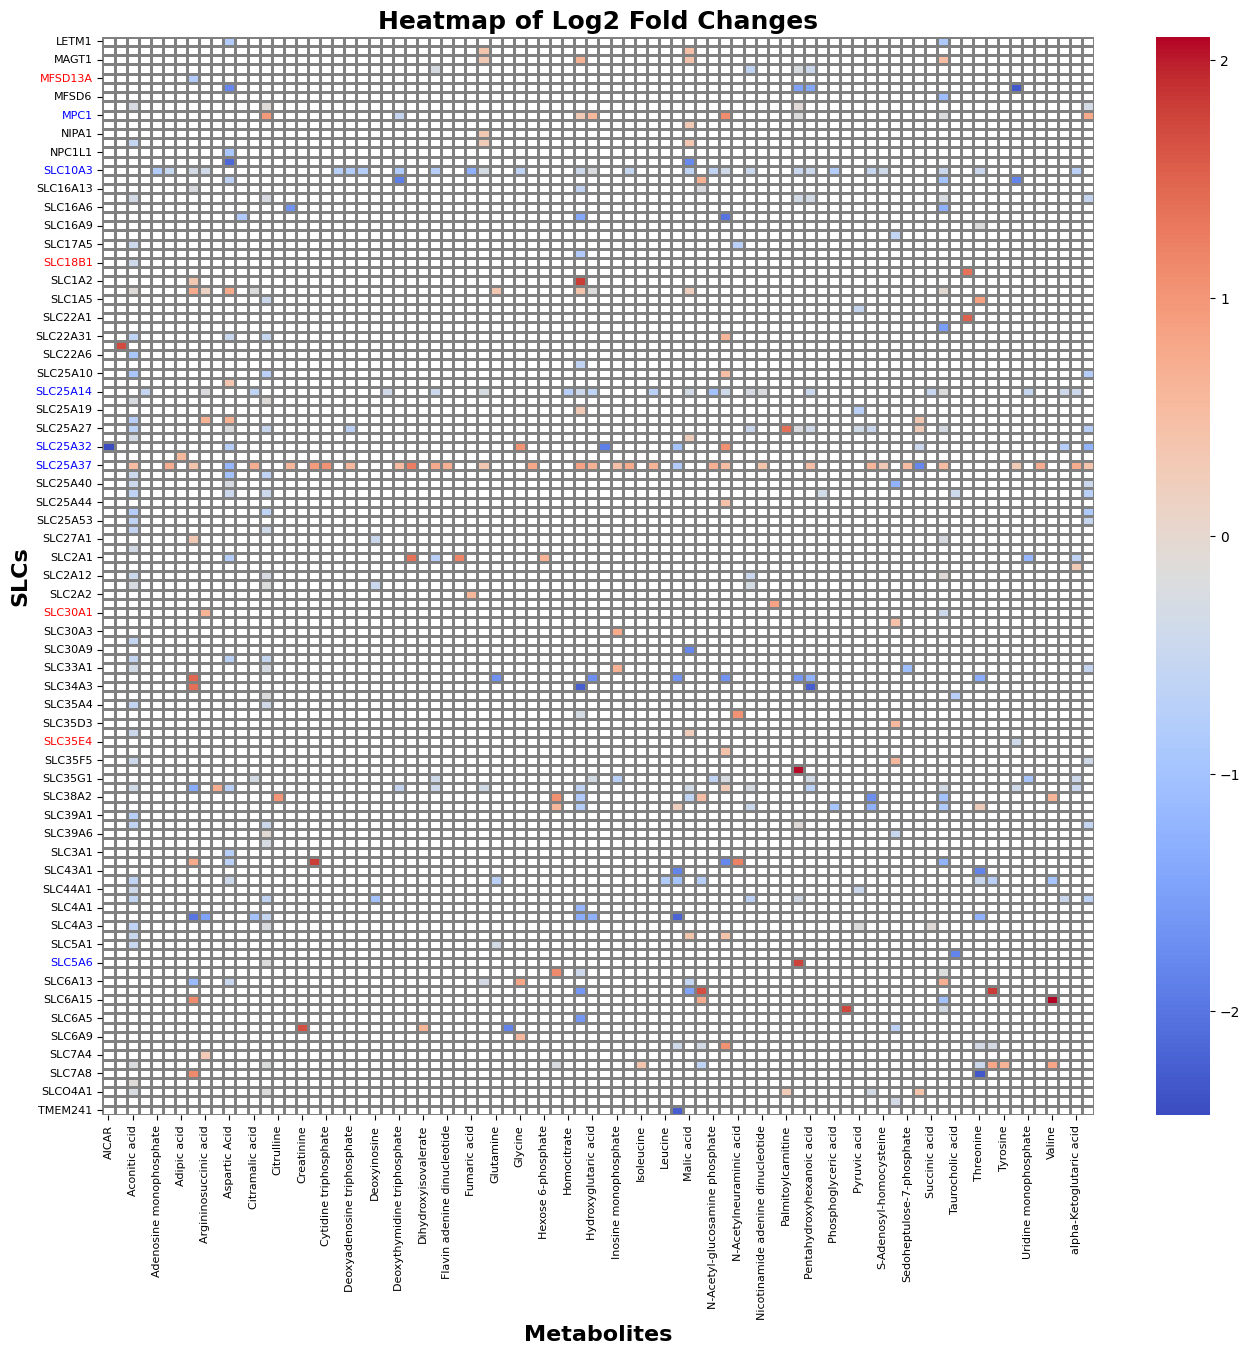

In [10]:
# Importing necessary libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Loading data from the Excel file
file_path = '/content/drive/MyDrive/Colab Notebooks/data_for_douglas 2/cleaned_targeted_metabolomics.xlsx'
sheet_name = 'Sheet1'

# Reading the Excel file into a DataFrame
df = pd.read_excel(file_path, sheet_name=sheet_name)

# Defining the exact values for known and unknown SLCs manually
known_slcs = [
    'SLC25A37',
    'SLC25A14',
    'SLC6A8',
    'SLC10A3',
    'SLC22A5',
    'SLC25A32',
    'SLC7A5',
    'MPC1',
    'SLC7A1',
    'SLC5A6'
]

unknown_slcs = [
    'SLC35G2',
    'MFSD11',
    'SLC35F6',
    'MFSD14B',
    'MFSD9',
    'SLC35E3',
    'SLC30A1',
    'SLC35E4',
    'SLC18B1',
    'MFSD13A'
]

# Pivoting the data to get SLCs as rows and metabolites as columns
heatmap_data = df.pivot(index='SLC', columns='metabolite', values='log2FC')

# Creating the heatmap without values inside the cells
plt.figure(figsize=(16, 14))  # Increase figure size for better readability
sns.heatmap(
    heatmap_data,
    cmap='coolwarm',
    cbar=True,
    linewidths=1.0,
    linecolor='gray',
    annot=False
)

# Highlighting known and unknown SLCs by manually adjusting the labels
ax = plt.gca()

# Adjusting the y-tick labels (SLCs) and x-tick labels (Metabolites)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=8)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=8)

# Iterating through the y-tick labels (SLCs) and adjust their color based on known/unknown
for label in ax.get_yticklabels():
    slc_name = label.get_text()
    if slc_name in known_slcs:
        label.set_color('blue')
    elif slc_name in unknown_slcs:
        label.set_color('red')
    else:
        label.set_color('black')

# Adding titles and labels
plt.title('Heatmap of Log2 Fold Changes', fontsize=18, fontweight='bold')
plt.xlabel('Metabolites', fontsize=16, fontweight='bold')
plt.ylabel('SLCs', fontsize=16, fontweight='bold')


# Saving the plot as a PNG
plt.savefig('/content/drive/MyDrive/Colab Notebooks/data_for_douglas 2/heatmap_plot.png', format='png')

# Displaying the plot
plt.show()


# **Violin Plot**

<ipython-input-11-c2ce3b68442b>:66: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='SLC_status', y='log2FC', data=df, palette={'Known': 'blue', 'Unknown': 'red', 'Other': 'gray'}, inner='point')


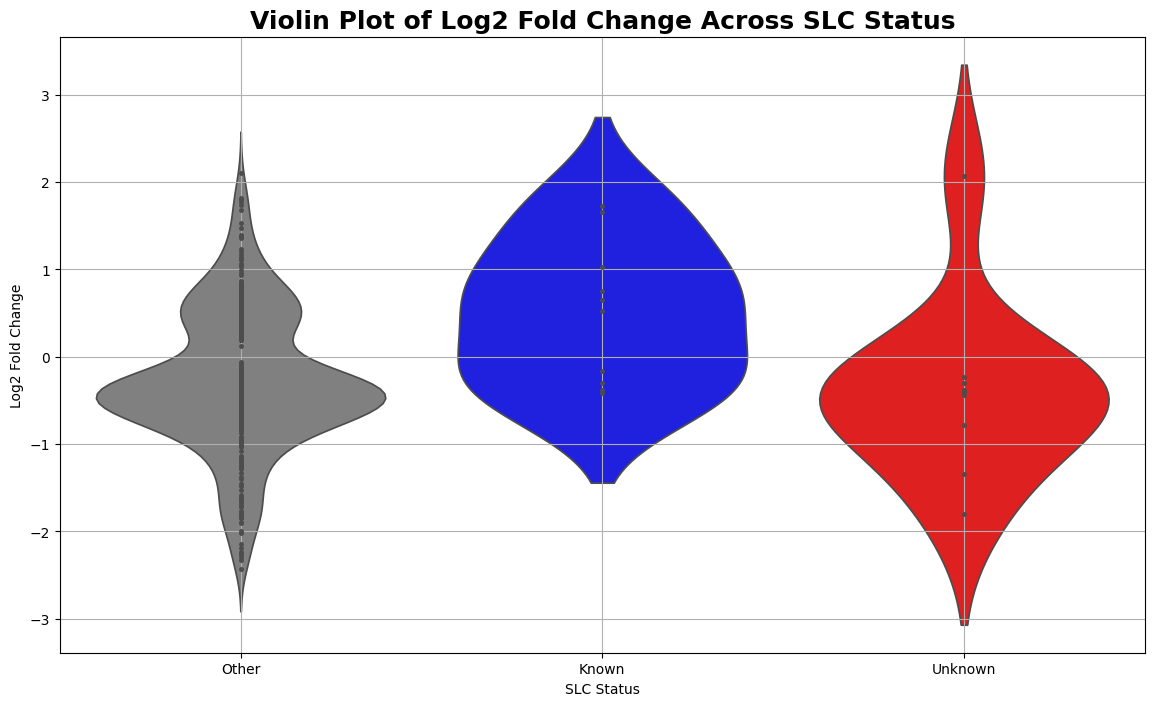

In [11]:
# Importing the necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Loading data from the Excel file
file_path = '/content/drive/MyDrive/Colab Notebooks/data_for_douglas 2/cleaned_targeted_metabolomics.xlsx'
sheet_name = 'Sheet1'

# Reading the Excel file into a DataFrame
df = pd.read_excel(file_path, sheet_name=sheet_name)

# Manually specifying the known and unknown SLCs
known_slcs = [
    {'cell_line_name': 'HCT116-SLC25A37-KOOE-Ct-R100230', 'SLC': 'SLC25A37', 'metabolite': 'N-Acetylglutamic acid'},
    {'cell_line_name': 'HCT116-SLC25A14-KOOE-Nt-R100230', 'SLC': 'SLC25A14', 'metabolite': 'N-Acetylglutamic acid'},
    {'cell_line_name': 'HCT116-SLC6A8-KOOE-Ct-R100356', 'SLC': 'SLC6A8', 'metabolite': 'Creatinine'},
    {'cell_line_name': 'HCT116-SLC10A3-KOOE-Ct-R100230', 'SLC': 'SLC10A3', 'metabolite': 'N-Carbamoyl-aspartic acid'},
    {'cell_line_name': 'HCT116-SLC22A5-KOOE-Ct-R100181', 'SLC': 'SLC22A5', 'metabolite': 'Acetylcarnitine'},
    {'cell_line_name': 'HCT116-SLC25A32-KOOE-Ct-R100236', 'SLC': 'SLC25A32', 'metabolite': 'Glycine'},
    {'cell_line_name': 'HCT116-SLC7A5-KOOE-Ct-R100240', 'SLC': 'SLC7A5', 'metabolite': 'Tyrosine'},
    {'cell_line_name': 'HCT116-MPC1-KOOE-Ct-R100252', 'SLC': 'MPC1', 'metabolite': 'cis-Aconitic acid'},
    {'cell_line_name': 'HCT116-SLC7A1-KOOE-Ct-R100268', 'SLC': 'SLC7A1', 'metabolite': 'Tryptophan'},
    {'cell_line_name': 'HCT116-SLC5A6-KOOE-Ct-R100268', 'SLC': 'SLC5A6', 'metabolite': 'Citric acid+Isocitric acid'}
]

unknown_slcs = [
    {'cell_line_name': '1321N1-SLC35G2-KOOE-Ct-R100230', 'SLC': 'SLC35G2', 'metabolite': 'Aminoadipic acid'},
    {'cell_line_name': 'HCT116-MFSD11-KOOE-Ct-R100239', 'SLC': 'MFSD11', 'metabolite': 'Pantothenic acid'},
    {'cell_line_name': 'HEK-SLC35F6-WTOE-Ct-R100290', 'SLC': 'SLC35F6', 'metabolite': 'Pantothenic acid'},
    {'cell_line_name': 'HEK-MFSD14B-WTOE-Nt-R100290', 'SLC': 'MFSD14B', 'metabolite': 'Aspartic Acid'},
    {'cell_line_name': 'HCT116-MFSD9-KOOE-Ct-R100239', 'SLC': 'MFSD9', 'metabolite': 'cis-Aconitic acid'},
    {'cell_line_name': 'HCT116-SLC35E3-KOOE-Ct-R100285', 'SLC': 'SLC35E3', 'metabolite': 'Aconitic acid'},
    {'cell_line_name': 'HCT116-SLC30A1-KOOE-Ct-R100226', 'SLC': 'SLC30A1', 'metabolite': 'Taurine'},
    {'cell_line_name': 'HCT116-SLC35E4-KOOE-Ct-R100285', 'SLC': 'SLC35E4', 'metabolite': 'Uridine diphosphohexose'},
    {'cell_line_name': 'HCT116-SLC18B1-KOOE-Ct-R100315', 'SLC': 'SLC18B1', 'metabolite': 'Aconitic acid'},
    {'cell_line_name': 'HEK-MFSD13A-WTOE-Ct-R100290', 'SLC': 'MFSD13A', 'metabolite': 'Aminoadipic acid'}
]

# Annotating Known and Unknown SLCs in the DataFrame
# Creating a new column in the DataFrame to label SLCs as 'Known', 'Unknown', or 'Other'
df['SLC_status'] = 'Other'

# Looping through known SLCs and mark them
for slc in known_slcs:
    df.loc[
        (df['cell_line_name'] == slc['cell_line_name']) &
        (df['SLC'] == slc['SLC']) &
        (df['metabolite'] == slc['metabolite']),
        'SLC_status'
    ] = 'Known'

# Looping through unknown SLCs and mark them
for slc in unknown_slcs:
    df.loc[
        (df['cell_line_name'] == slc['cell_line_name']) &
        (df['SLC'] == slc['SLC']) &
        (df['metabolite'] == slc['metabolite']),
        'SLC_status'
    ] = 'Unknown'

# Creating the Violin Plot
plt.figure(figsize=(14, 8))

# Using seaborn's violinplot function
sns.violinplot(x='SLC_status', y='log2FC', data=df, palette={'Known': 'blue', 'Unknown': 'red', 'Other': 'gray'}, inner='point')

# Adding labels and title
plt.xlabel('SLC Status')
plt.ylabel('Log2 Fold Change')
plt.title('Violin Plot of Log2 Fold Change Across SLC Status',fontsize=18, fontweight='bold')
plt.grid(True)

# Saving the plot as a PDF
plt.savefig('/content/drive/MyDrive/Colab Notebooks/data_for_douglas 2/violin_plot.png', format='png')

# Displaying the plot
plt.show()


# **Correlation Matrix (Metabolites)**

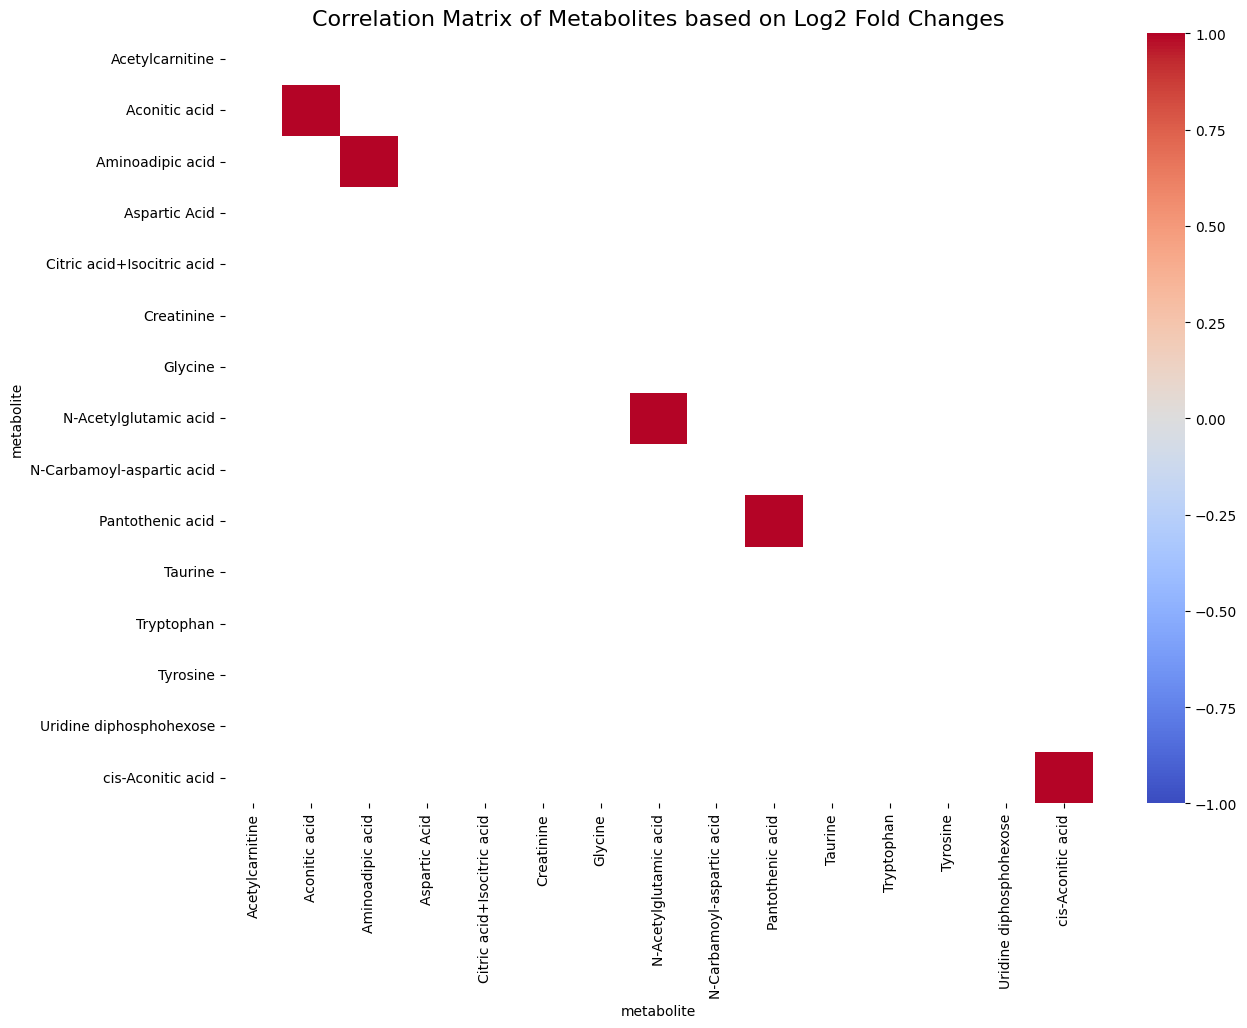

In [12]:
# Importing the necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Loading data from an Excel file
file_path = '/content/drive/MyDrive/Colab Notebooks/data_for_douglas 2/cleaned_targeted_metabolomics.xlsx'
sheet_name = 'Sheet1'

# Reading the Excel file into a DataFrame
df = pd.read_excel(file_path, sheet_name=sheet_name)

# Manually specifying the known and unknown SLCs
known_slcs = [
    {'cell_line_name': 'HCT116-SLC25A37-KOOE-Ct-R100230', 'SLC': 'SLC25A37', 'metabolite': 'N-Acetylglutamic acid'},
    {'cell_line_name': 'HCT116-SLC25A14-KOOE-Nt-R100230', 'SLC': 'SLC25A14', 'metabolite': 'N-Acetylglutamic acid'},
    {'cell_line_name': 'HCT116-SLC6A8-KOOE-Ct-R100356', 'SLC': 'SLC6A8', 'metabolite': 'Creatinine'},
    {'cell_line_name': 'HCT116-SLC10A3-KOOE-Ct-R100230', 'SLC': 'SLC10A3', 'metabolite': 'N-Carbamoyl-aspartic acid'},
    {'cell_line_name': 'HCT116-SLC22A5-KOOE-Ct-R100181', 'SLC': 'SLC22A5', 'metabolite': 'Acetylcarnitine'},
    {'cell_line_name': 'HCT116-SLC25A32-KOOE-Ct-R100236', 'SLC': 'SLC25A32', 'metabolite': 'Glycine'},
    {'cell_line_name': 'HCT116-SLC7A5-KOOE-Ct-R100240', 'SLC': 'SLC7A5', 'metabolite': 'Tyrosine'},
    {'cell_line_name': 'HCT116-MPC1-KOOE-Ct-R100252', 'SLC': 'MPC1', 'metabolite': 'cis-Aconitic acid'},
    {'cell_line_name': 'HCT116-SLC7A1-KOOE-Ct-R100268', 'SLC': 'SLC7A1', 'metabolite': 'Tryptophan'},
    {'cell_line_name': 'HCT116-SLC5A6-KOOE-Ct-R100268', 'SLC': 'SLC5A6', 'metabolite': 'Citric acid+Isocitric acid'}
]

unknown_slcs = [
    {'cell_line_name': '1321N1-SLC35G2-KOOE-Ct-R100230', 'SLC': 'SLC35G2', 'metabolite': 'Aminoadipic acid'},
    {'cell_line_name': 'HCT116-MFSD11-KOOE-Ct-R100239', 'SLC': 'MFSD11', 'metabolite': 'Pantothenic acid'},
    {'cell_line_name': 'HEK-SLC35F6-WTOE-Ct-R100290', 'SLC': 'SLC35F6', 'metabolite': 'Pantothenic acid'},
    {'cell_line_name': 'HEK-MFSD14B-WTOE-Nt-R100290', 'SLC': 'MFSD14B', 'metabolite': 'Aspartic Acid'},
    {'cell_line_name': 'HCT116-MFSD9-KOOE-Ct-R100239', 'SLC': 'MFSD9', 'metabolite': 'cis-Aconitic acid'},
    {'cell_line_name': 'HCT116-SLC35E3-KOOE-Ct-R100285', 'SLC': 'SLC35E3', 'metabolite': 'Aconitic acid'},
    {'cell_line_name': 'HCT116-SLC30A1-KOOE-Ct-R100226', 'SLC': 'SLC30A1', 'metabolite': 'Taurine'},
    {'cell_line_name': 'HCT116-SLC35E4-KOOE-Ct-R100285', 'SLC': 'SLC35E4', 'metabolite': 'Uridine diphosphohexose'},
    {'cell_line_name': 'HCT116-SLC18B1-KOOE-Ct-R100315', 'SLC': 'SLC18B1', 'metabolite': 'Aconitic acid'},
    {'cell_line_name': 'HEK-MFSD13A-WTOE-Ct-R100290', 'SLC': 'MFSD13A', 'metabolite': 'Aminoadipic acid'}
]

# Annotating Known and Unknown SLCs in the DataFrame
# Creating a new column in the DataFrame to label SLCs as 'Known', 'Unknown', or 'Other'
df['SLC_status'] = 'Other'

# Looping through known SLCs and mark them
for slc in known_slcs:
    df.loc[
        (df['cell_line_name'] == slc['cell_line_name']) &
        (df['SLC'] == slc['SLC']) &
        (df['metabolite'] == slc['metabolite']),
        'SLC_status'
    ] = 'Known'

# Looping through unknown SLCs and mark them
for slc in unknown_slcs:
    df.loc[
        (df['cell_line_name'] == slc['cell_line_name']) &
        (df['SLC'] == slc['SLC']) &
        (df['metabolite'] == slc['metabolite']),
        'SLC_status'
    ] = 'Unknown'

# Filtering the DataFrame to include only the selected SLCs (Known and Unknown)
filtered_df = df[df['SLC_status'].isin(['Known', 'Unknown'])]

# Preparing data for the correlation matrix
# Pivoting the data to create a matrix with SLCs as rows and metabolites as columns
pivot_df = filtered_df.pivot_table(index='SLC', columns='metabolite', values='log2FC')

# Calculating the correlation matrix
correlation_matrix = pivot_df.corr()

# Creating the Correlation Matrix Plot
plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', vmin=-1, vmax=1, cbar=True)

# Adding title
plt.title('Correlation Matrix of Metabolites based on Log2 Fold Changes', fontsize=16)


# Saving the plot as a PDF
plt.savefig('/content/drive/MyDrive/Colab Notebooks/data_for_douglas 2/correlation_meta_heatmap_plot.png', format='png')

# Displaying the plot
plt.show()


# **Correlation Matrix (SLCs)**

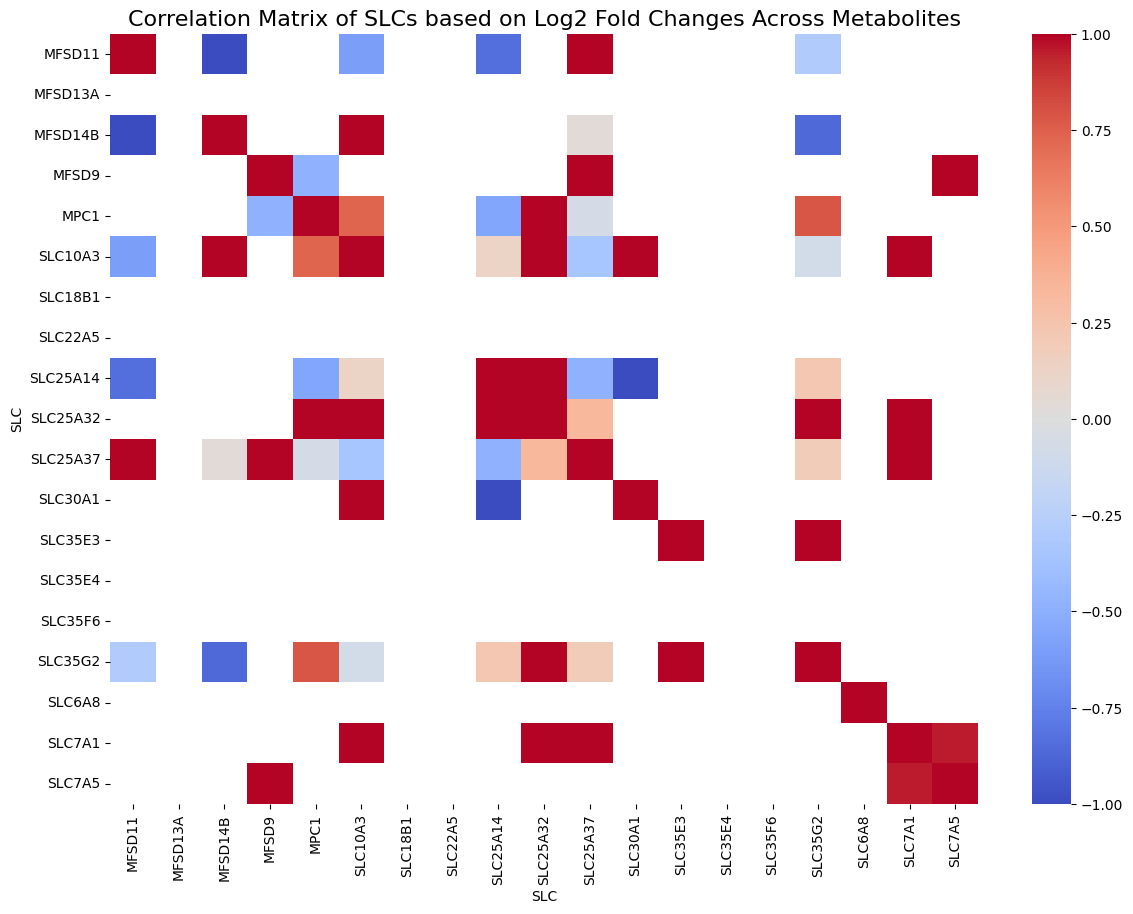

In [13]:
# Importing the necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Loading data from an Excel file
file_path = '/content/drive/MyDrive/Colab Notebooks/data_for_douglas 2/cleaned_targeted_metabolomics.xlsx'
sheet_name = 'Sheet1'

# Reading the Excel file into a DataFrame
df = pd.read_excel(file_path, sheet_name=sheet_name)

# Filtering the DataFrame to include only the known and unknown SLCs
selected_slcs = [
    'SLC25A37', 'SLC25A14', 'SLC6A8', 'SLC10A3', 'SLC22A5',
    'SLC25A32', 'SLC7A5', 'MPC1', 'SLC7A1', 'SLC35G2',
    'MFSD11', 'SLC35F6', 'MFSD14B', 'MFSD9', 'SLC35E3',
    'SLC30A1', 'SLC35E4', 'SLC18B1', 'MFSD13A'
]

df_filtered = df[df['SLC'].isin(selected_slcs)]

# Pivoting the DataFrame to create a matrix with SLCs as rows and metabolites as columns
pivot_df = df_filtered.pivot_table(index='SLC', columns='metabolite', values='log2FC')

# Calculating the correlation matrix for SLCs
correlation_matrix_slcs = pivot_df.T.corr()

# Creating the Correlation Matrix Plot for SLCs
plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix_slcs, annot=False, cmap='coolwarm', vmin=-1, vmax=1, cbar=True)

# Adding title
plt.title('Correlation Matrix of SLCs based on Log2 Fold Changes Across Metabolites', fontsize=16)


# Saving the plot as a PDF
plt.savefig('/content/drive/MyDrive/Colab Notebooks/data_for_douglas 2/correlation_slc_heatmap_plot.png', format='png')

# Displaying the plot
plt.show()


# **PCA Plot**

Filtered Data:
 metabolite  AICAR  Acetylcarnitine  Aconitic acid  \
SLC                                                 
MFSD11        0.0              0.0       0.000000   
MFSD13A       0.0              0.0       0.000000   
MFSD14B       0.0              0.0       0.000000   
MFSD9         0.0              0.0      -0.249658   
MPC1          0.0              0.0       0.000000   

metabolite  Adenosine cyclic monophosphate  Adenosine monophosphate  \
SLC                                                                   
MFSD11                                 0.0                      0.0   
MFSD13A                                0.0                      0.0   
MFSD14B                                0.0                      0.0   
MFSD9                                  0.0                      0.0   
MPC1                                   0.0                      0.0   

metabolite  Adenosine triphosphate  Aminoadipic acid  Argininosuccinic acid  \
SLC                                

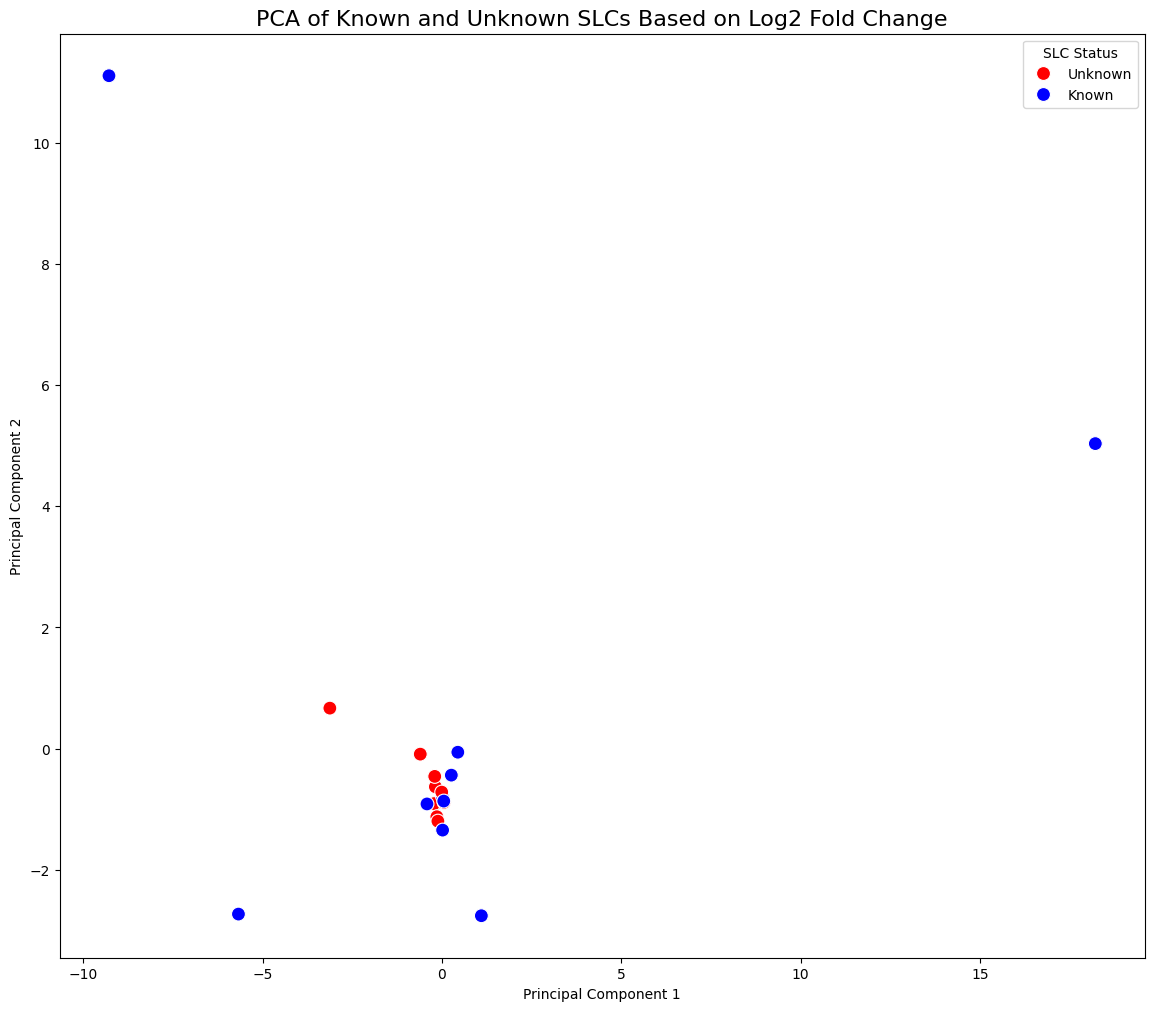

In [14]:
# Importing the necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sns

# Loading data from an Excel file
file_path = '/content/drive/MyDrive/Colab Notebooks/data_for_douglas 2/cleaned_targeted_metabolomics.xlsx'
sheet_name = 'Sheet1'

# Reading the Excel file into a DataFrame
df = pd.read_excel(file_path, sheet_name=sheet_name)

# Manually specifying the known and unknown SLCs
known_slcs = [
    'SLC25A37', 'SLC25A14', 'SLC6A8', 'SLC10A3', 'SLC22A5',
    'SLC25A32', 'SLC7A5', 'MPC1', 'SLC7A1', 'SLC5A6'
]

unknown_slcs = [
    'SLC35G2', 'MFSD11', 'SLC35F6', 'MFSD14B', 'MFSD9',
    'SLC35E3', 'SLC30A1', 'SLC35E4', 'SLC18B1', 'MFSD13A'
]

# Filtering the DataFrame to include only the known and unknown SLCs
df_filtered = df[df['SLC'].isin(known_slcs + unknown_slcs)]

# Pivoting the data to create a matrix with SLCs as rows and metabolites as columns
X = df_filtered.pivot_table(index='SLC', columns='metabolite', values='log2FC').fillna(0)

# Verifying the filtered data
print("Filtered Data:\n", X.head())

# Standardizing the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Performing PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Annotating the SLCs as known or unknown
y = ['Known' if slc in known_slcs else 'Unknown' for slc in X.index]

# Ploting the PCA results
plt.figure(figsize=(14, 12 ))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y, palette={'Known': 'blue', 'Unknown': 'red'}, s=100)
plt.title('PCA of Known and Unknown SLCs Based on Log2 Fold Change', fontsize=16)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='SLC Status')

# Saving the plot as a PDF
plt.savefig('/content/drive/MyDrive/Colab Notebooks/data_for_douglas 2/pca_plot_1.png', format='png')

# Displaying the plot
plt.show()


# **CORRELATION ANALYSIS**

In [15]:
# Importing the necessary libraries
import pandas as pd

# Loading the Metabolomics dataset
metabolomics_file = '/content/drive/MyDrive/Colab Notebooks/data_for_douglas 2/cleaned_targeted_metabolomics.xlsx'
metabolomics_df = pd.read_excel(metabolomics_file, sheet_name='Sheet1')

# Loading Transcriptomics datasets
transcriptomics_file_1 = '/content/drive/MyDrive/Colab Notebooks/data_for_douglas 2/cleaned_transcriptomics1.xlsx'
transcriptomics_file_2 = '/content/drive/MyDrive/Colab Notebooks/data_for_douglas 2/cleaned_transcriptomics2.xlsx'
transcriptomics_file_3 = '/content/drive/MyDrive/Colab Notebooks/data_for_douglas 2/cleaned_transcriptomics3.xlsx'

transcriptomics_df1 = pd.read_excel(transcriptomics_file_1, sheet_name='Sheet1')
transcriptomics_df2 = pd.read_excel(transcriptomics_file_2, sheet_name='Sheet1')
transcriptomics_df3 = pd.read_excel(transcriptomics_file_3, sheet_name='Sheet1')


In [16]:
# Manually specifying the known and unknown SLCs
known_slcs = [
    {'cell_line_name': 'HCT116-SLC25A37-KOOE-Ct-R100230', 'SLC': 'SLC25A37', 'metabolite': 'N-Acetylglutamic acid'},
    {'cell_line_name': 'HCT116-SLC25A14-KOOE-Nt-R100230', 'SLC': 'SLC25A14', 'metabolite': 'N-Acetylglutamic acid'},
    {'cell_line_name': 'HCT116-SLC6A8-KOOE-Ct-R100356', 'SLC': 'SLC6A8', 'metabolite': 'Creatinine'},
    {'cell_line_name': 'HCT116-SLC10A3-KOOE-Ct-R100230', 'SLC': 'SLC10A3', 'metabolite': 'N-Carbamoyl-aspartic acid'},
    {'cell_line_name': 'HCT116-SLC22A5-KOOE-Ct-R100181', 'SLC': 'SLC22A5', 'metabolite': 'Acetylcarnitine'},
    {'cell_line_name': 'HCT116-SLC25A32-KOOE-Ct-R100236', 'SLC': 'SLC25A32', 'metabolite': 'Glycine'},
    {'cell_line_name': 'HCT116-SLC7A5-KOOE-Ct-R100240', 'SLC': 'SLC7A5', 'metabolite': 'Tyrosine'},
    {'cell_line_name': 'HCT116-MPC1-KOOE-Ct-R100252', 'SLC': 'MPC1', 'metabolite': 'cis-Aconitic acid'},
    {'cell_line_name': 'HCT116-SLC7A1-KOOE-Ct-R100268', 'SLC': 'SLC7A1', 'metabolite': 'Tryptophan'},
    {'cell_line_name': 'HCT116-SLC5A6-KOOE-Ct-R100268', 'SLC': 'SLC5A6', 'metabolite': 'Citric acid+Isocitric acid'}
]

unknown_slcs = [
    {'cell_line_name': '1321N1-SLC35G2-KOOE-Ct-R100230', 'SLC': 'SLC35G2', 'metabolite': 'Aminoadipic acid'},
    {'cell_line_name': 'HCT116-MFSD11-KOOE-Ct-R100239', 'SLC': 'MFSD11', 'metabolite': 'Pantothenic acid'},
    {'cell_line_name': 'HEK-SLC35F6-WTOE-Ct-R100290', 'SLC': 'SLC35F6', 'metabolite': 'Pantothenic acid'},
    {'cell_line_name': 'HEK-MFSD14B-WTOE-Nt-R100290', 'SLC': 'MFSD14B', 'metabolite': 'Aspartic Acid'},
    {'cell_line_name': 'HCT116-MFSD9-KOOE-Ct-R100239', 'SLC': 'MFSD9', 'metabolite': 'cis-Aconitic acid'},
    {'cell_line_name': 'HCT116-SLC35E3-KOOE-Ct-R100285', 'SLC': 'SLC35E3', 'metabolite': 'Aconitic acid'},
    {'cell_line_name': 'HCT116-SLC30A1-KOOE-Ct-R100226', 'SLC': 'SLC30A1', 'metabolite': 'Taurine'},
    {'cell_line_name': 'HCT116-SLC35E4-KOOE-Ct-R100285', 'SLC': 'SLC35E4', 'metabolite': 'Uridine diphosphohexose'},
    {'cell_line_name': 'HCT116-SLC18B1-KOOE-Ct-R100315', 'SLC': 'SLC18B1', 'metabolite': 'Aconitic acid'},
    {'cell_line_name': 'HEK-MFSD13A-WTOE-Ct-R100290', 'SLC': 'MFSD13A', 'metabolite': 'Aminoadipic acid'}
]


# Converting known and unknown SLCs lists to DataFrames for easy merging
known_slcs_df = pd.DataFrame(known_slcs)
unknown_slcs_df = pd.DataFrame(unknown_slcs)

# Filtering metabolomics data for known and unknown SLCs
known_metabolomics = metabolomics_df[metabolomics_df['SLC'].isin(known_slcs_df['SLC'])]
unknown_metabolomics = metabolomics_df[metabolomics_df['SLC'].isin(unknown_slcs_df['SLC'])]


In [17]:
# Merging the filtered metabolomics data with each transcriptomics dataset based on SLC
merged_known_df1 = pd.merge(known_metabolomics, transcriptomics_df1, left_on='SLC', right_on='external_gene_name')
merged_known_df2 = pd.merge(known_metabolomics, transcriptomics_df2, left_on='SLC', right_on='external_gene_name')
merged_known_df3 = pd.merge(known_metabolomics, transcriptomics_df3, left_on='SLC', right_on='external_gene_name')

merged_unknown_df1 = pd.merge(unknown_metabolomics, transcriptomics_df1, left_on='SLC', right_on='external_gene_name')
merged_unknown_df2 = pd.merge(unknown_metabolomics, transcriptomics_df2, left_on='SLC', right_on='external_gene_name')
merged_unknown_df3 = pd.merge(unknown_metabolomics, transcriptomics_df3, left_on='SLC', right_on='external_gene_name')

# Calculating correlation for each pair (log2FC from metabolomics vs. log2FoldChange from transcriptomics)
def calculate_correlation(merged_df):
    return merged_df[['log2FC', 'log2FoldChange']].corr().iloc[0, 1]

# Calculating correlations for known and unknown SLCs
correlation_known_1 = calculate_correlation(merged_known_df1)
correlation_known_2 = calculate_correlation(merged_known_df2)
correlation_known_3 = calculate_correlation(merged_known_df3)

correlation_unknown_1 = calculate_correlation(merged_unknown_df1)
correlation_unknown_2 = calculate_correlation(merged_unknown_df2)
correlation_unknown_3 = calculate_correlation(merged_unknown_df3)

# Outputing the correlations
print(f'Correlation between Metabolomics and Transcriptomics 1 for known SLCs: {correlation_known_1}')
print(f'Correlation between Metabolomics and Transcriptomics 2 for known SLCs: {correlation_known_2}')
print(f'Correlation between Metabolomics and Transcriptomics 3 for known SLCs: {correlation_known_3}')
print(f'Correlation between Metabolomics and Transcriptomics 1 for unknown SLCs: {correlation_unknown_1}')
print(f'Correlation between Metabolomics and Transcriptomics 2 for unknown SLCs: {correlation_unknown_2}')
print(f'Correlation between Metabolomics and Transcriptomics 3 for unknown SLCs: {correlation_unknown_3}')


Correlation between Metabolomics and Transcriptomics 1 for known SLCs: -0.08237447275921173
Correlation between Metabolomics and Transcriptomics 2 for known SLCs: 0.09695899709621156
Correlation between Metabolomics and Transcriptomics 3 for known SLCs: -0.05423362494760669
Correlation between Metabolomics and Transcriptomics 1 for unknown SLCs: 0.0013158427273364669
Correlation between Metabolomics and Transcriptomics 2 for unknown SLCs: -5.1048089000063826e-05
Correlation between Metabolomics and Transcriptomics 3 for unknown SLCs: -0.09103835071894209


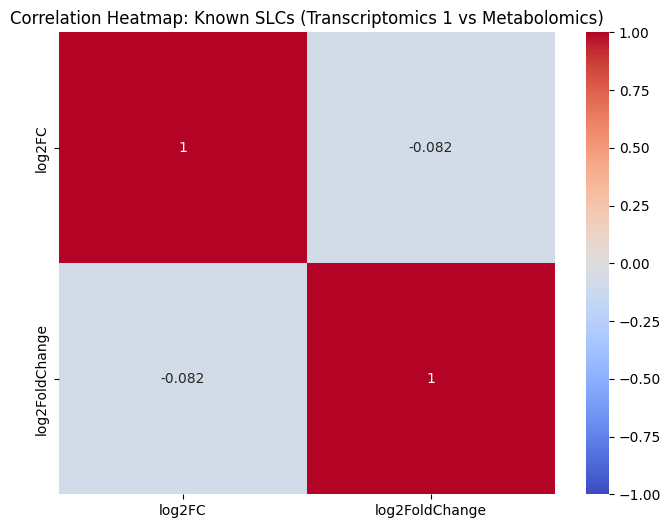

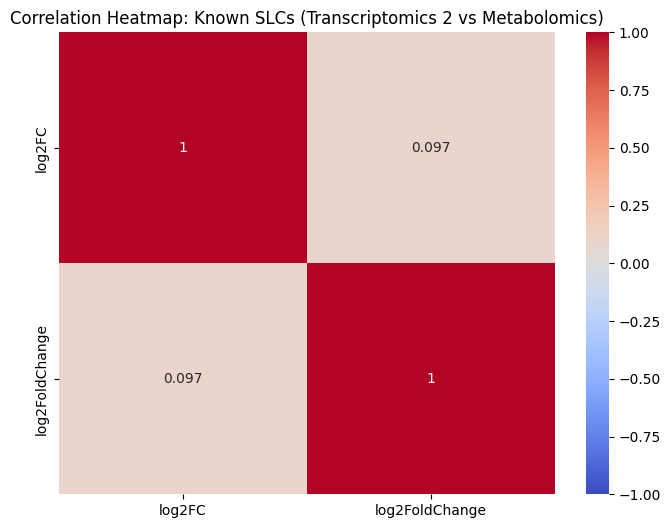

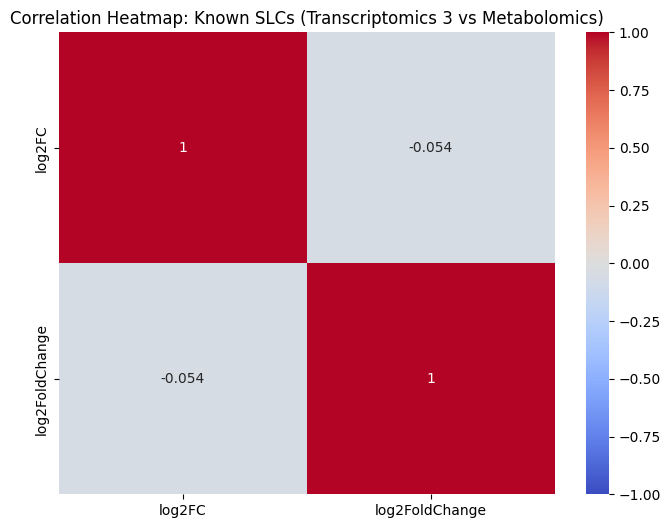

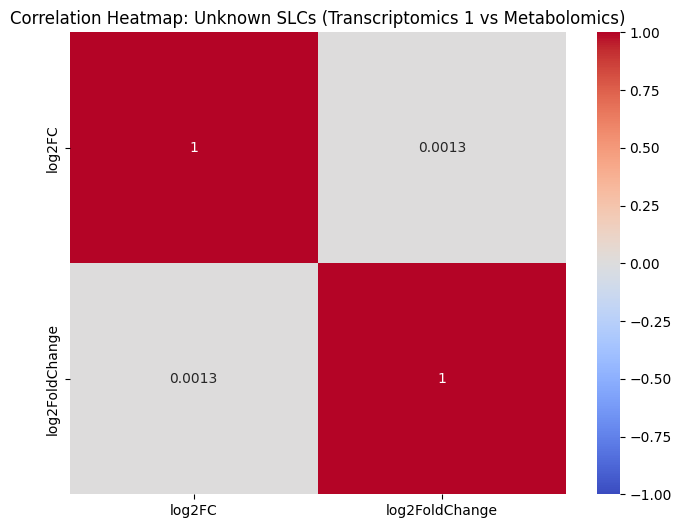

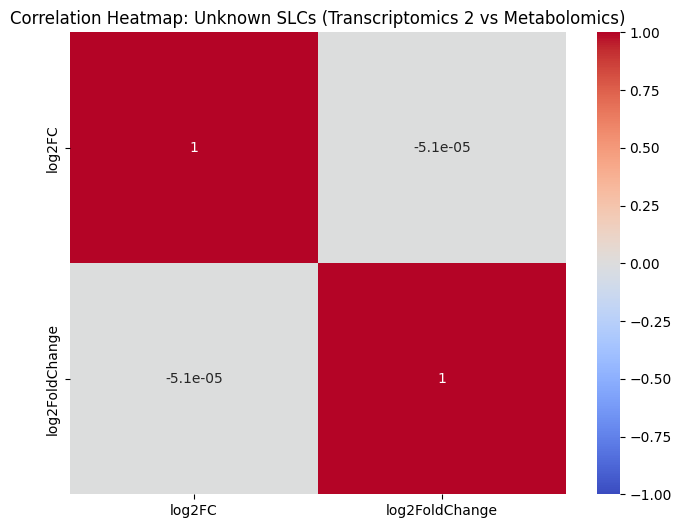

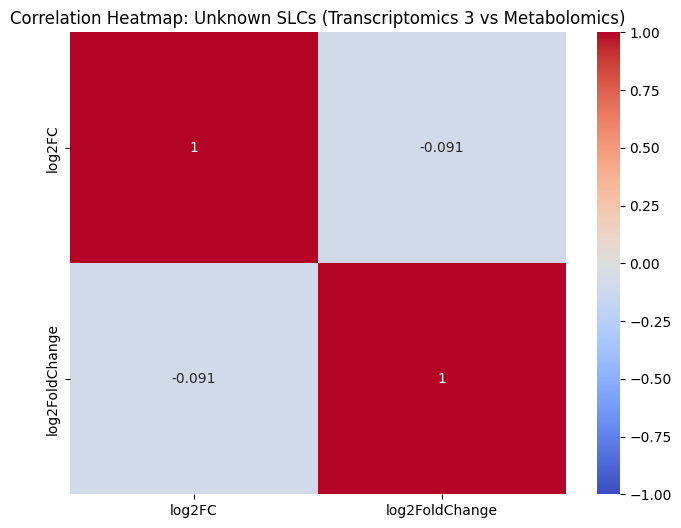

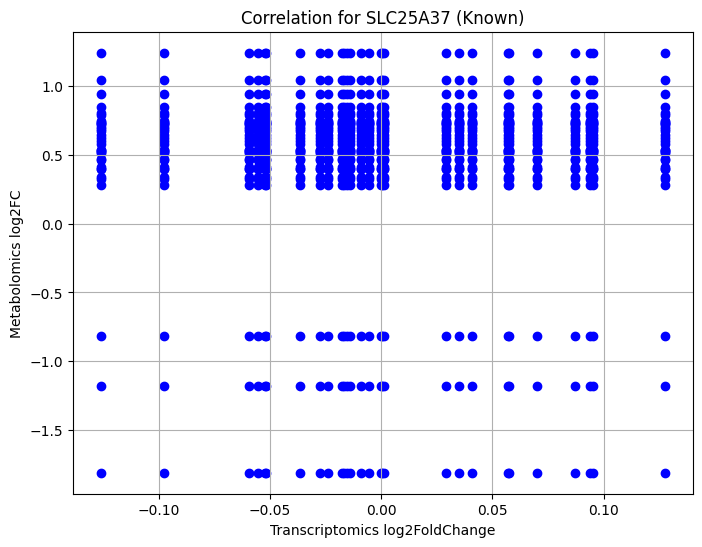

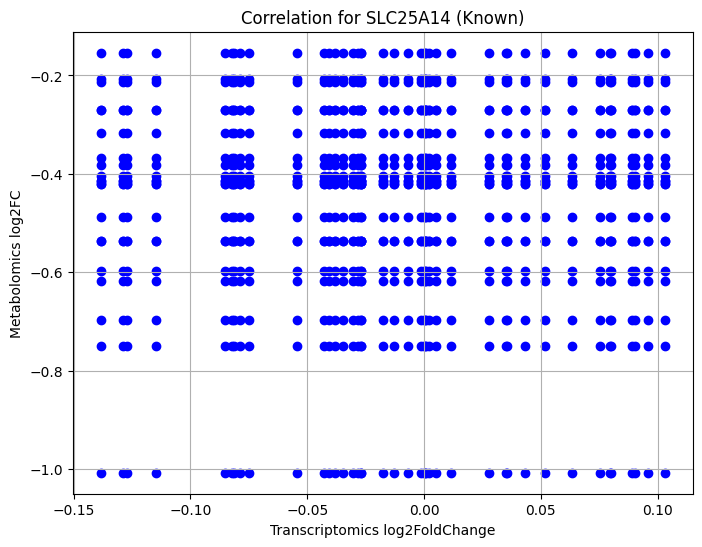

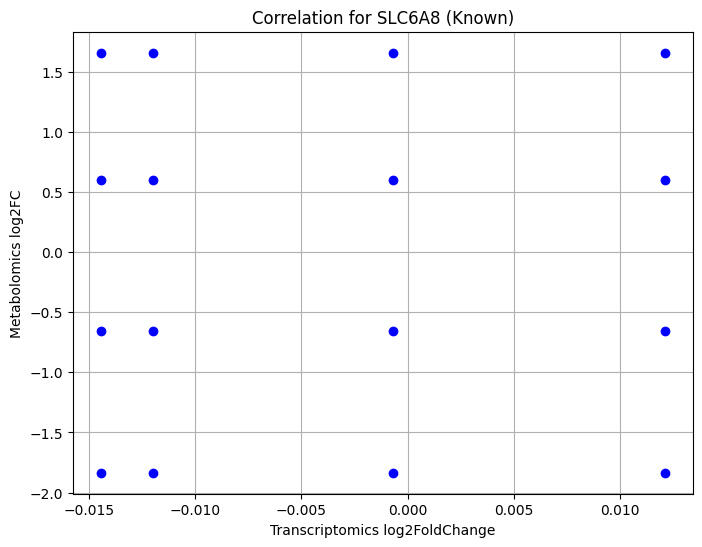

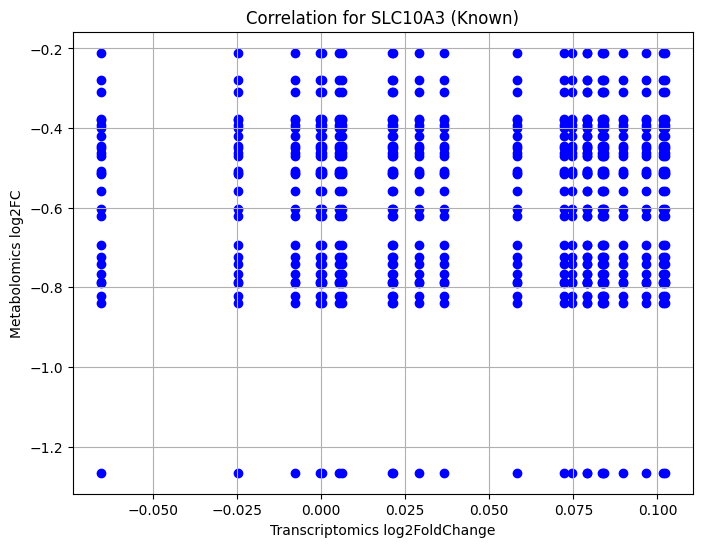

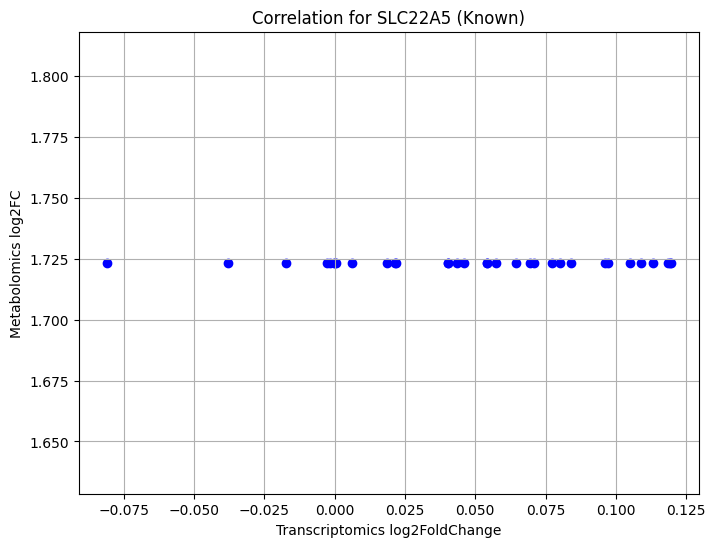

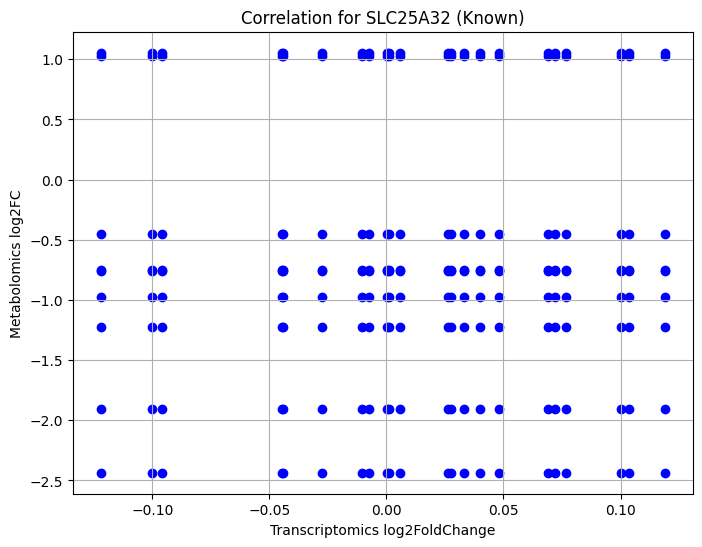

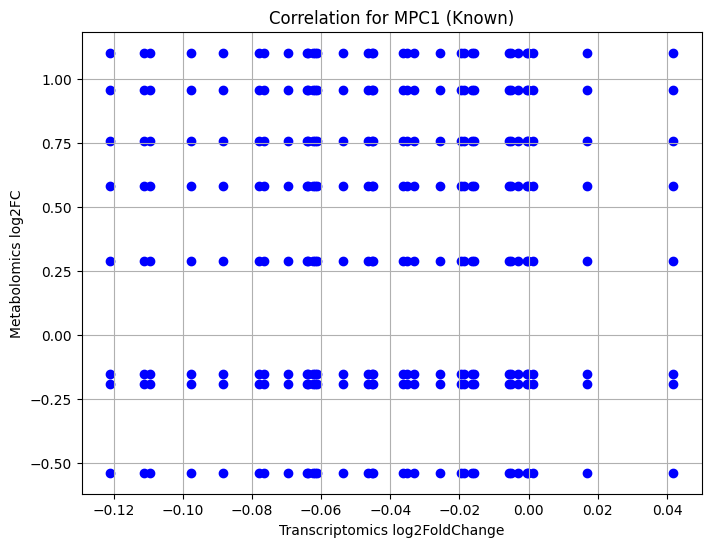

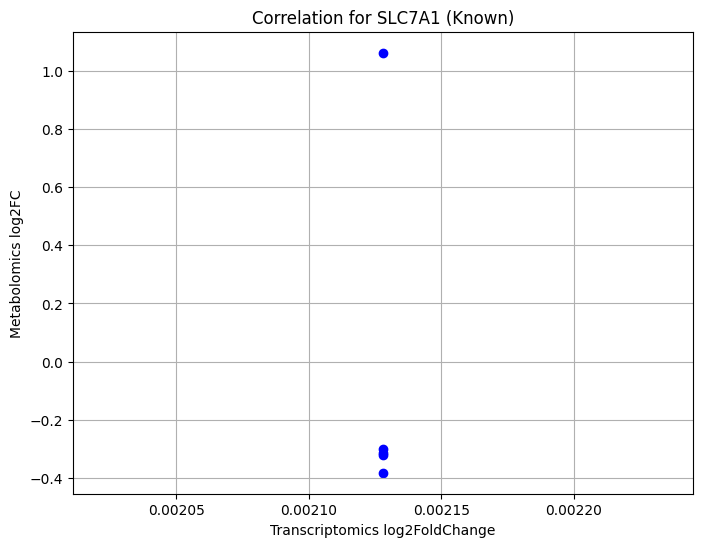

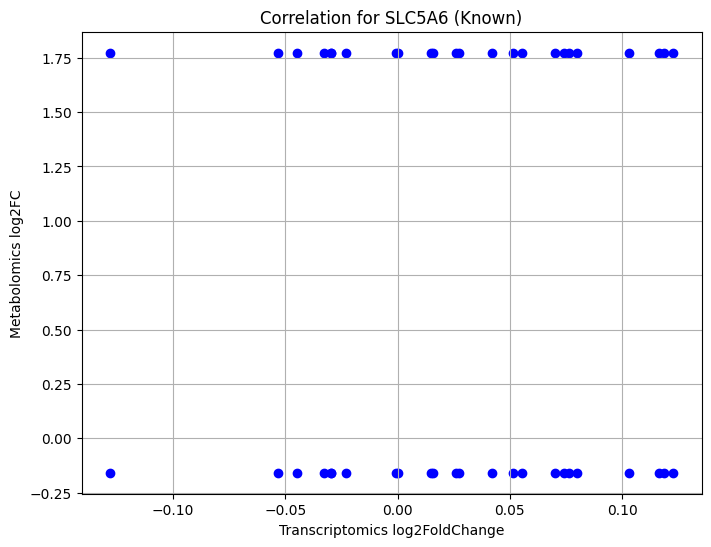

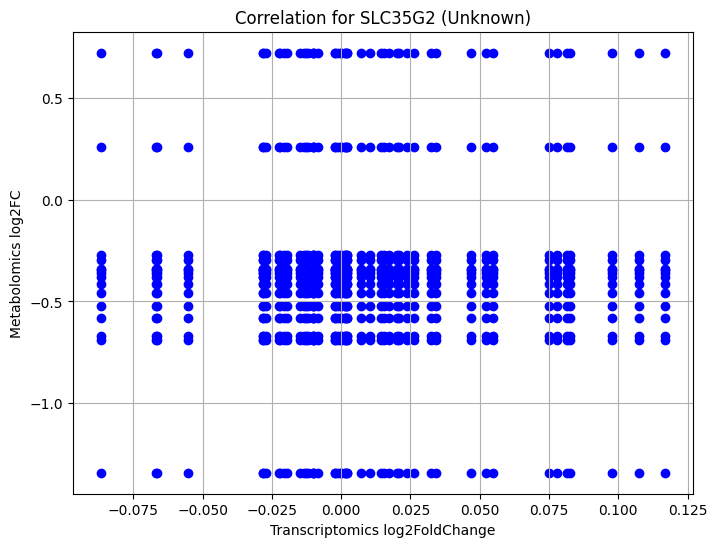

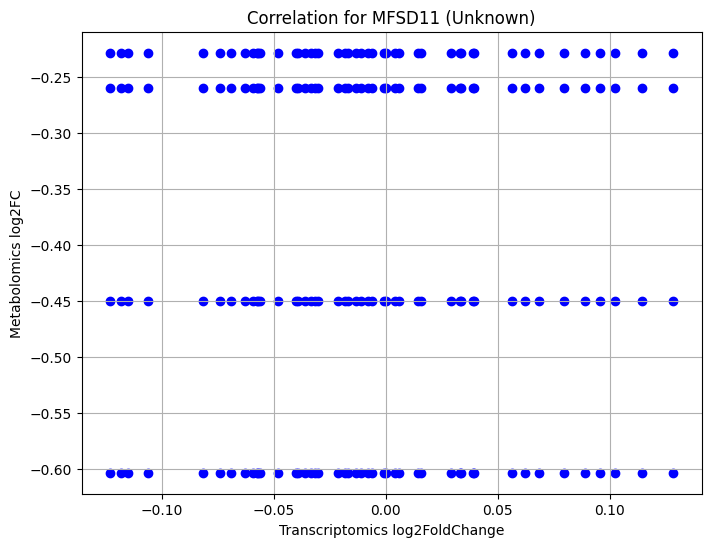

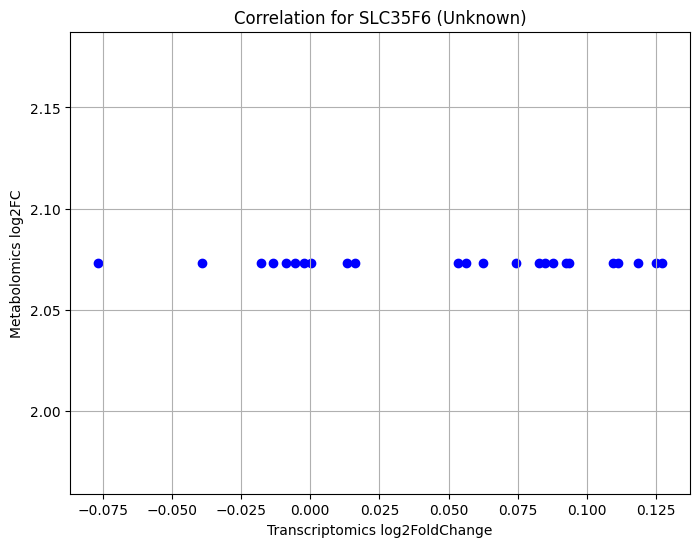

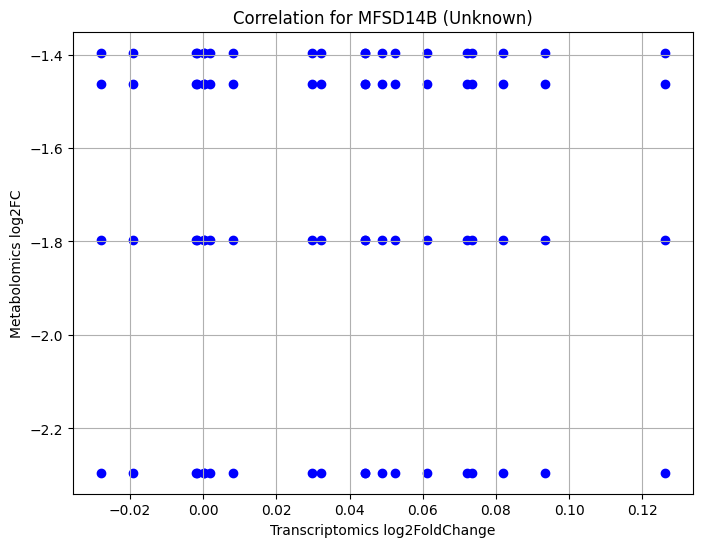

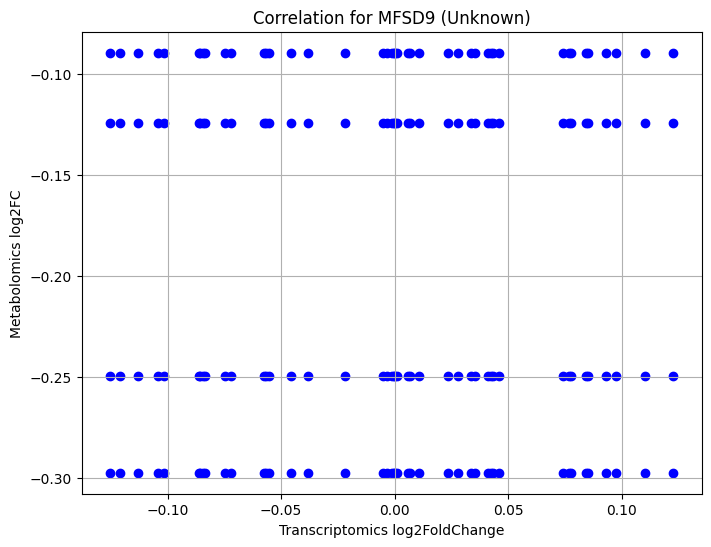

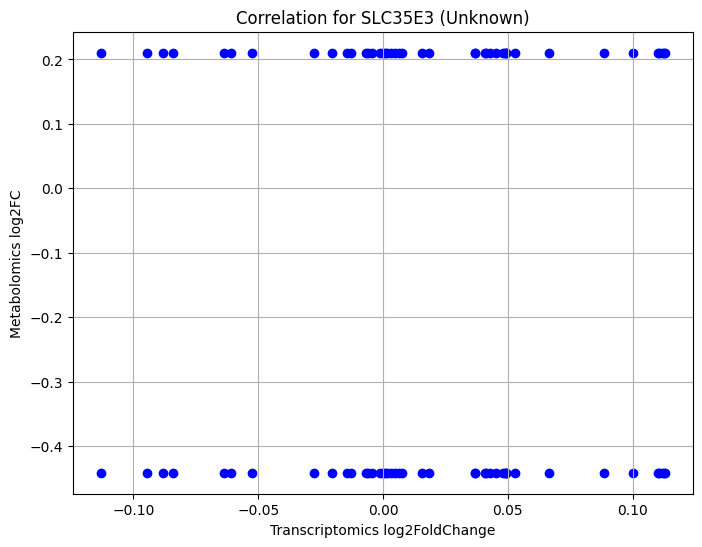

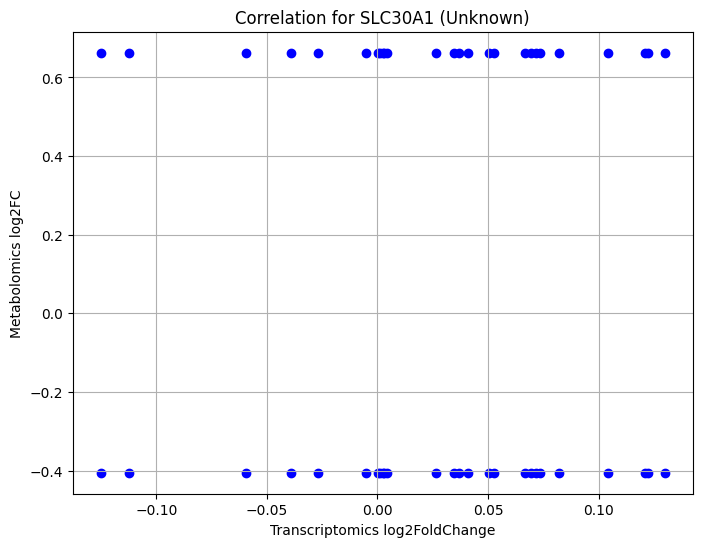

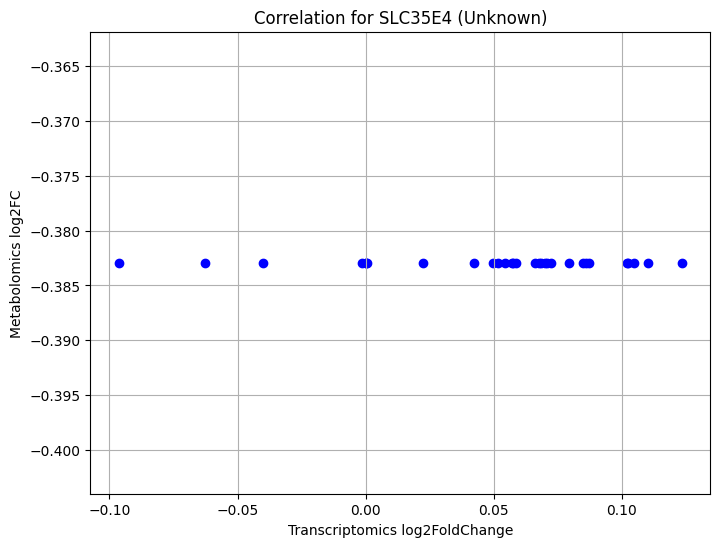

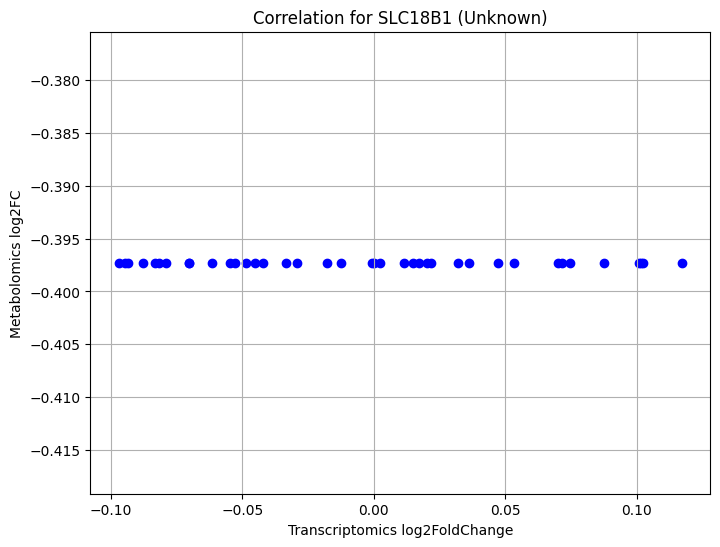

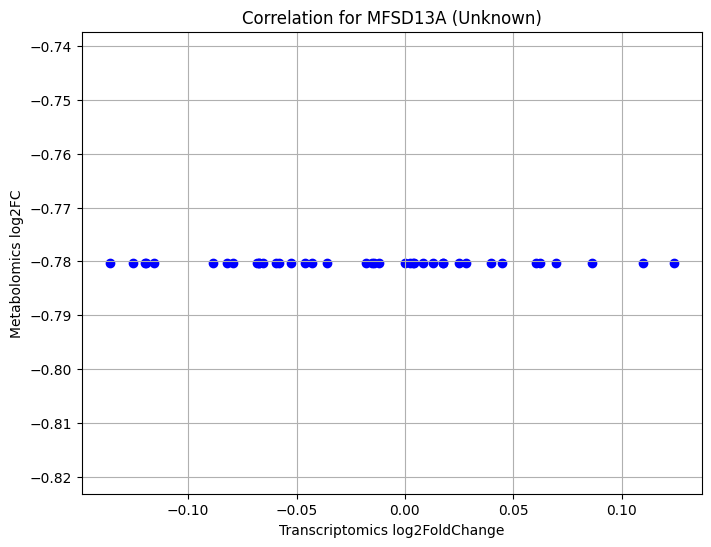

In [18]:
# Importing the necessary libraries
import seaborn as sns
import matplotlib.pyplot as plt
import os

# Ensuring the directory exists for saving plots
output_dir = '/content/drive/MyDrive/Colab Notebooks/data_for_douglas 2'
os.makedirs(output_dir, exist_ok=True)

# Heatmap plotting function
def plot_heatmap(data, title, filename):
    plt.figure(figsize=(8, 6))
    sns.heatmap(data, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title(title)
    plt.savefig(os.path.join(output_dir, filename), format='png')
    plt.show()

# Scatter plot function
def plot_scatter(data, title, filename):
    plt.figure(figsize=(8, 6))
    plt.scatter(data['log2FoldChange'], data['log2FC'], color='blue')
    plt.xlabel('Transcriptomics log2FoldChange')
    plt.ylabel('Metabolomics log2FC')
    plt.title(title)
    plt.grid(True)
    plt.savefig(os.path.join(output_dir, filename), format='png')
    plt.show()

# Ploting heatmaps for each condition
conditions = [
    (merged_known_df1, 'Correlation Heatmap: Known SLCs (Transcriptomics 1 vs Metabolomics)', 'heatmap_known_trans1.png'),
    (merged_known_df2, 'Correlation Heatmap: Known SLCs (Transcriptomics 2 vs Metabolomics)', 'heatmap_known_trans2.png'),
    (merged_known_df3, 'Correlation Heatmap: Known SLCs (Transcriptomics 3 vs Metabolomics)', 'heatmap_known_trans3.png'),
    (merged_unknown_df1, 'Correlation Heatmap: Unknown SLCs (Transcriptomics 1 vs Metabolomics)', 'heatmap_unknown_trans1.png'),
    (merged_unknown_df2, 'Correlation Heatmap: Unknown SLCs (Transcriptomics 2 vs Metabolomics)', 'heatmap_unknown_trans2.png'),
    (merged_unknown_df3, 'Correlation Heatmap: Unknown SLCs (Transcriptomics 3 vs Metabolomics)', 'heatmap_unknown_trans3.png')
]

for df, title, filename in conditions:
    correlation_data = df[['log2FC', 'log2FoldChange']].corr()
    plot_heatmap(correlation_data, title, filename)

# Scatter plots for all known and unknown SLCs
for slc in known_slcs + unknown_slcs:
    slc_data_known = merged_known_df1[merged_known_df1['SLC'] == slc['SLC']]
    slc_data_unknown = merged_unknown_df1[merged_unknown_df1['SLC'] == slc['SLC']]

    if not slc_data_known.empty:
        title = f"Correlation for {slc['SLC']} (Known)"
        filename = f"scatter_known_{slc['SLC']}.png"
        plot_scatter(slc_data_known, title, filename)

    if not slc_data_unknown.empty:
        title = f"Correlation for {slc['SLC']} (Unknown)"
        filename = f"scatter_unknown_{slc['SLC']}.png"
        plot_scatter(slc_data_unknown, title, filename)

    # Catch case where SLC might not be found in either
    if slc_data_known.empty and slc_data_unknown.empty:
        print(f"Warning: No data found for SLC {slc['SLC']}. Plot not generated.")


# **NETWORK ANALYSIS**

<ipython-input-19-325627cbbfc0>:67: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  known_patch = mpatches.Patch(color='#1f77b4', label='Known SLC', edgecolor='black')
<ipython-input-19-325627cbbfc0>:68: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  unknown_patch = mpatches.Patch(color='#ff7f0e', label='Unknown SLC', edgecolor='black')
<ipython-input-19-325627cbbfc0>:69: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  metabolite_patch = mpatches.Patch(color='#2ca02c', label='Metabolite', edgecolor='black')


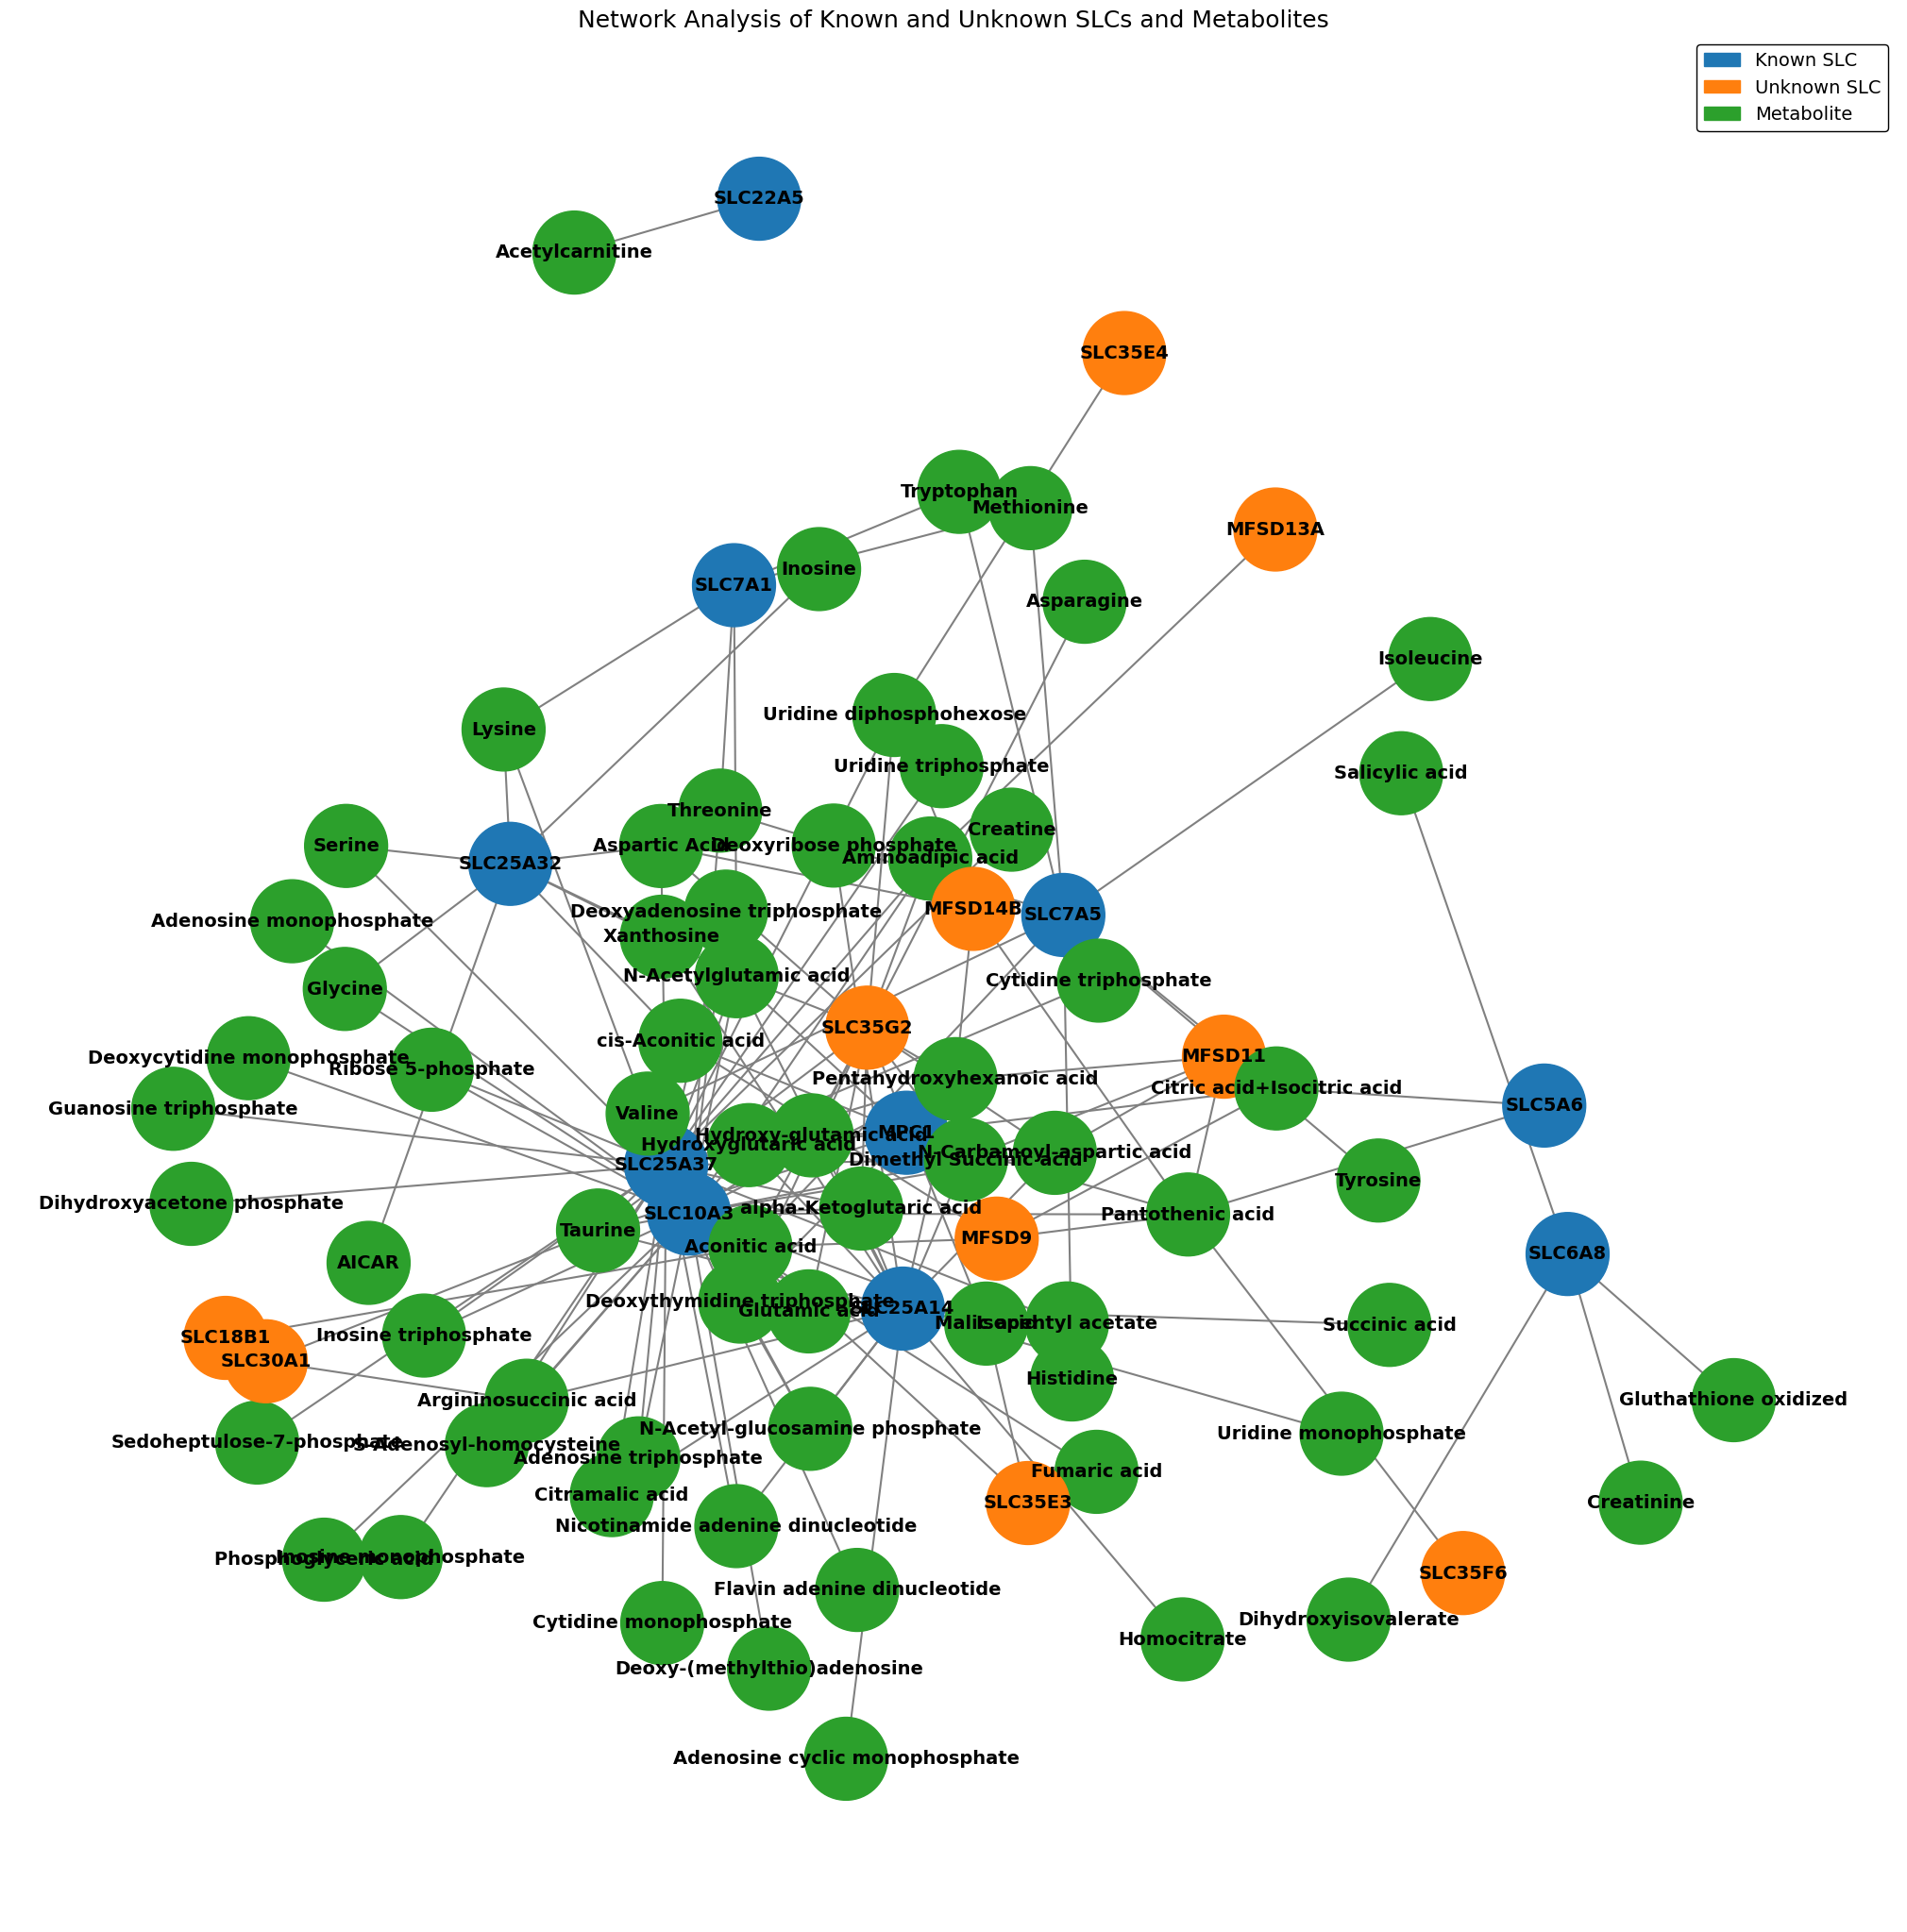

In [19]:
# Importing all the necessary libraries
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Loading your datasets
metabolomics_file = '/content/drive/MyDrive/Colab Notebooks/data_for_douglas 2/cleaned_metabolomics_selectedSLCs.xlsx'
metabolomics_df = pd.read_excel(metabolomics_file)

# Manually identifying known and unknown SLCs
known_slcs = [
    'SLC25A37', 'SLC25A14', 'SLC6A8', 'SLC10A3', 'SLC22A5',
    'SLC25A32', 'SLC7A5', 'MPC1', 'SLC7A1', 'SLC5A6'
]

unknown_slcs = [
    'SLC35G2', 'MFSD11', 'SLC35F6', 'MFSD14B', 'MFSD9',
    'SLC35E3', 'SLC30A1', 'SLC35E4', 'SLC18B1', 'MFSD13A'
]

# Filtering the metabolomics data for the known and unknown SLCs
filtered_metabolomics = metabolomics_df[
    metabolomics_df['SLC'].isin(known_slcs + unknown_slcs)
]

# Creating a network graph
G = nx.Graph()

# Adding nodes for SLCs and metabolites based on filtered data
for _, row in filtered_metabolomics.iterrows():
    slc_name = row['SLC']
    metabolite_name = row['metabolite']

    # Determining if the SLC is known or unknown
    slc_status = 'Known' if slc_name in known_slcs else 'Unknown'

    G.add_node(slc_name, type='SLC', status=slc_status)
    G.add_node(metabolite_name, type='Metabolite')
    G.add_edge(slc_name, metabolite_name)

# Setting node colors based on type and status
node_colors = []
for node, data in G.nodes(data=True):
    if data['type'] == 'SLC':
        if data['status'] == 'Known':
            node_colors.append('#1f77b4')  # Blue for known SLCs
        else:
            node_colors.append('#ff7f0e')  # Orange for unknown SLCs
    else:
        node_colors.append('#2ca02c')  # Green for metabolites

# Setting edge colors and widths
edge_colors = ['gray' for _ in G.edges()]
edge_widths = [1.5 for _ in G.edges()]  # Slightly thinner edges for clarity

# Using a layout that spreads nodes out more
plt.figure(figsize=(20, 20))
pos = nx.spring_layout(G, k=1.5, iterations=200)  # Increased k for more spacing

# Drawing the network with adjusted parameters for better readability
nx.draw(G, pos, with_labels=True, node_color=node_colors, edge_color=edge_colors,
        width=edge_widths, node_size=4000, font_size=14, font_weight='bold',
        font_color='black', edge_cmap=plt.cm.Blues, edge_vmin=0.5, edge_vmax=4)

# Adding a legend with black text for SLCs
known_patch = mpatches.Patch(color='#1f77b4', label='Known SLC', edgecolor='black')
unknown_patch = mpatches.Patch(color='#ff7f0e', label='Unknown SLC', edgecolor='black')
metabolite_patch = mpatches.Patch(color='#2ca02c', label='Metabolite', edgecolor='black')
plt.legend(handles=[known_patch, unknown_patch, metabolite_patch], loc='upper right', fontsize=14, facecolor='white', edgecolor='black', framealpha=1)

plt.title('Network Analysis of Known and Unknown SLCs and Metabolites', fontsize=18)

# Saving the table as an image
plt.savefig('/content/drive/MyDrive/Colab Notebooks/data_for_douglas 2/Network_Analysis_plot.png', format='png')

plt.show()


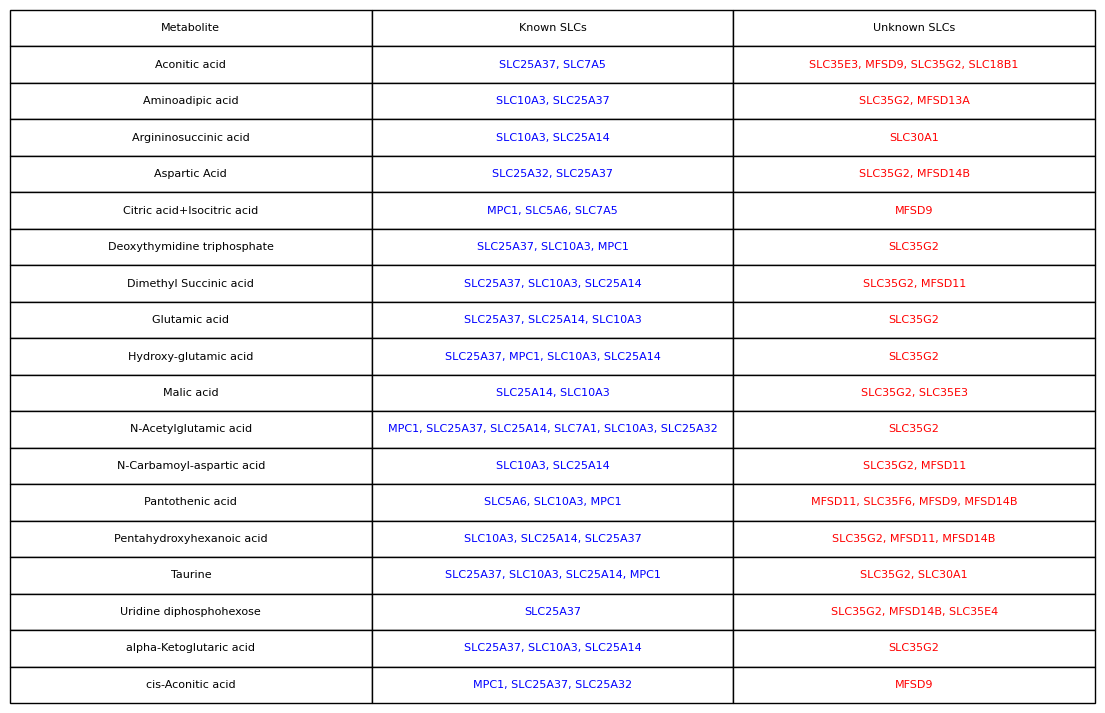

In [20]:
# Importing the necessary packages
import matplotlib.pyplot as plt
from matplotlib.table import Table

# Grouping the data by metabolite and gather known and unknown SLCs for each metabolite
metabolite_group = filtered_metabolomics.groupby('metabolite')['SLC'].apply(list).reset_index()

# Initializing lists to hold the results
known_sls_list = []
unknown_sls_list = []

# Populating the lists with known and unknown SLCs for each metabolite
for slcs in metabolite_group['SLC']:
    known = [slc for slc in slcs if slc in known_slcs]
    unknown = [slc for slc in slcs if slc in unknown_slcs]
    known_sls_list.append(', '.join(known))
    unknown_sls_list.append(', '.join(unknown))

# Creating the resulting DataFrame
result_df = pd.DataFrame({
    'Metabolite': metabolite_group['metabolite'],
    'Known SLCs': known_sls_list,
    'Unknown SLCs': unknown_sls_list
})

# Filtering out rows where either Known SLCs or Unknown SLCs is empty (i.e., no common metabolite)
result_df = result_df[(result_df['Known SLCs'] != '') & (result_df['Unknown SLCs'] != '')]

# Plotting the table as an image
fig, ax = plt.subplots(figsize=(14, len(result_df) * 0.5))
ax.axis('tight')
ax.axis('off')

table = ax.table(cellText=result_df.values,
                 colLabels=result_df.columns,
                 cellLoc='center',
                 loc='center',
                 bbox=[0, 0, 1, 1])

# Highlighting known and unknown SLCs in the table
for i in range(len(result_df)):
    # Known SLCs in blue
    table[(i+1, 1)].set_text_props(color='blue')
    # Unknown SLCs in red
    table[(i+1, 2)].set_text_props(color='red')

table.auto_set_font_size(False)
table.set_fontsize(8)
table.scale(1.3, 1.3)  # Adjust table scale for readability

# Saving the table as an image
plt.savefig('/content/drive/MyDrive/Colab Notebooks/data_for_douglas 2/shared_metabolites_known_unknown.png', format='png')
plt.show()
